#**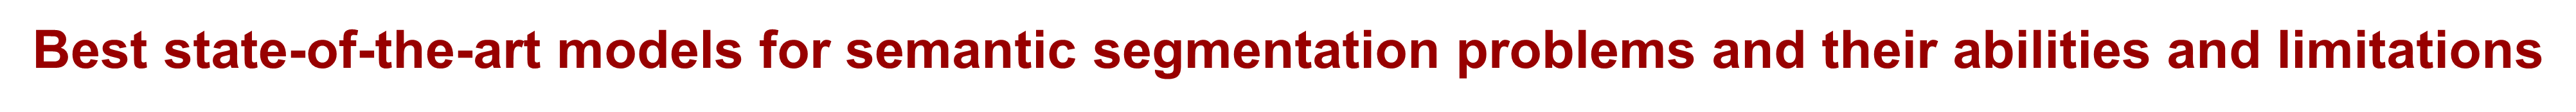**

*Author: Angelika Żyła*

#**Project goal**

The primary objective of this project is to leverage the Breast Ultrasound Dataset to develop a robust and accurate machine learning model for the early detection and diagnosis of breast cancer.


# **Libraries**

In [8]:

import tensorflow as tf
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from tensorflow.keras.metrics import *

The Breast Ultrasound Dataset is a collection of medical images obtained through ultrasound scans, designed to aid in the early detection and accurate diagnosis of breast cancer. This dataset is instrumental in developing machine learning models that can significantly improve the classification, detection, and segmentation of breast cancer, ultimately helping to reduce mortality rates among women.

The dataset features medical images from 600 female patients aged between 25 and 75 years, collected in the year 2018. It includes a total of 780 images, each with an average resolution of 500x500 pixels, and all images are provided in PNG format. The images are categorized into three distinct classes: normal, benign, and malignant, reflecting the different conditions that can be observed in breast tissue.

In addition to the original images, the dataset also includes ground truth images, which serve as a reference for validating the accuracy of machine learning models. These annotated images provide critical insights for training algorithms to differentiate between normal, benign, and malignant breast tissues effectively.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/drive/MyDrive/dataset_project/archive (5).zip'

# Define the extraction path
extract_path = '/content/drive/MyDrive/dataset_breast'

# Create the extraction folder if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/drive/MyDrive/dataset_breast


In [9]:
paths = glob('/content/drive/MyDrive/dataset_breast/Dataset_BUSI_with_GT/*/*')

print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")

'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [10]:
sorted(glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/*'))[4:7]

[]

<a id="3.2"></a>
## <span style="color:#08bf2c;"> Loading data </span>

In [11]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [12]:
size = 128   # image size: 128x128
X, y = load_data('/content/drive/MyDrive/dataset_breast/Dataset_BUSI_with_GT/*/*', size)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

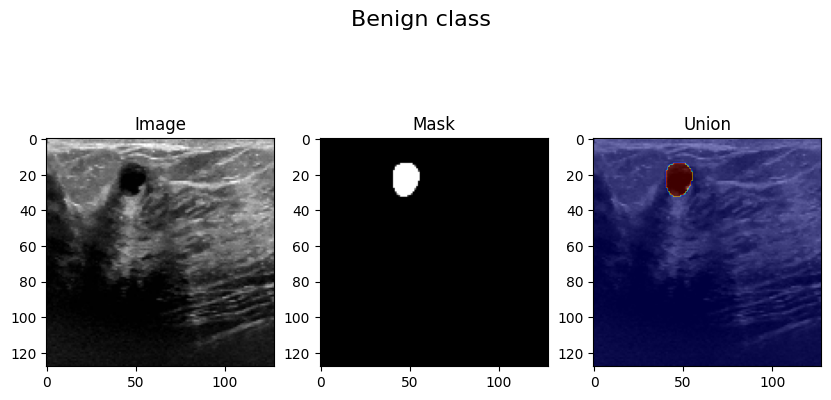

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

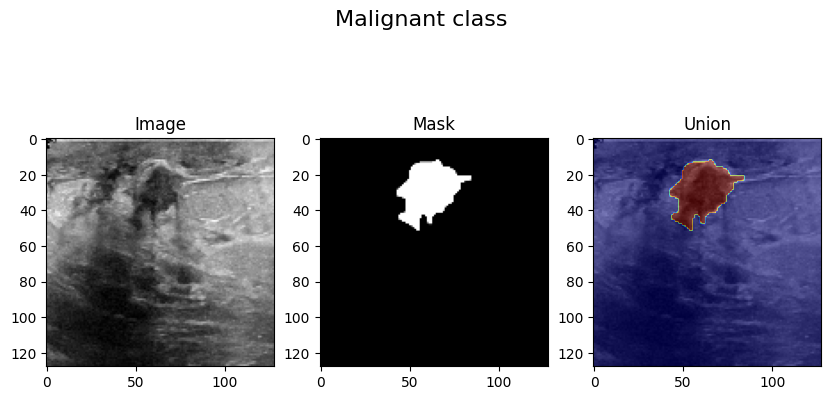

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

<a id="4.2"></a>
## <span style="color:#08bf2c;"> Average view of masks each class </span>

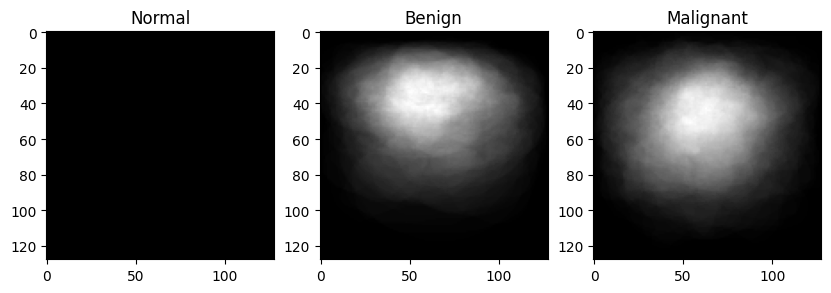

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

### <span style="color:#2981d9;"> Prepare data to modeling </span>

In [13]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


### <span style="color:#2981d9;"> Train-test split </span>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)



# **Model 1 - U-Net Architecture**

### <span style="color:#2981d9;"> Conv block </span>

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

### <span style="color:#2981d9;"> Encoder block </span>

In [ ]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

### <span style="color:#2981d9;"> Decoder block </span>

In [ ]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

##**Final Model**

In [ ]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

### <span style="color:#2981d9;"> Model summary </span>

In [ ]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 64)         640       ['input_3[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_20[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_21[0][0]']           
 g2D)                                                                                         

<a id="6.2"></a>
## <span style="color:#08bf2c;"> Training </span>

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
19/19 [==============================] - 28s 625ms/step - loss: 0.4847 - accuracy: 0.8553 - val_loss: 0.3260 - val_accuracy: 0.9100
Epoch 2/100
19/19 [==============================] - 7s 365ms/step - loss: 0.4371 - accuracy: 0.8838 - val_loss: 0.3298 - val_accuracy: 0.9100
Epoch 3/100
19/19 [==============================] - 7s 353ms/step - loss: 0.3323 - accuracy: 0.9037 - val_loss: 0.3026 - val_accuracy: 0.9100
Epoch 4/100
19/19 [==============================] - 7s 356ms/step - loss: 0.3113 - accuracy: 0.9034 - val_loss: 0.2801 - val_accuracy: 0.9100
Epoch 5/100
19/19 [==============================] - 7s 348ms/step - loss: 0.3241 - accuracy: 0.8987 - val_loss: 0.3056 - val_accuracy: 0.9100
Epoch 6/100
19/19 [==============================] - 7s 353ms/step - loss: 0.3060 - accuracy: 0.9037 - val_loss: 0.2928 - val_accuracy: 0.9100
Epoch 7/100
19/19 [==============================] - 7s 346ms/step - loss: 0.3076 - accuracy: 0.9037 - val_loss: 0.2942 - val_accuracy: 0.910

In [ ]:
import pandas as pd

##**Results - Model 1**

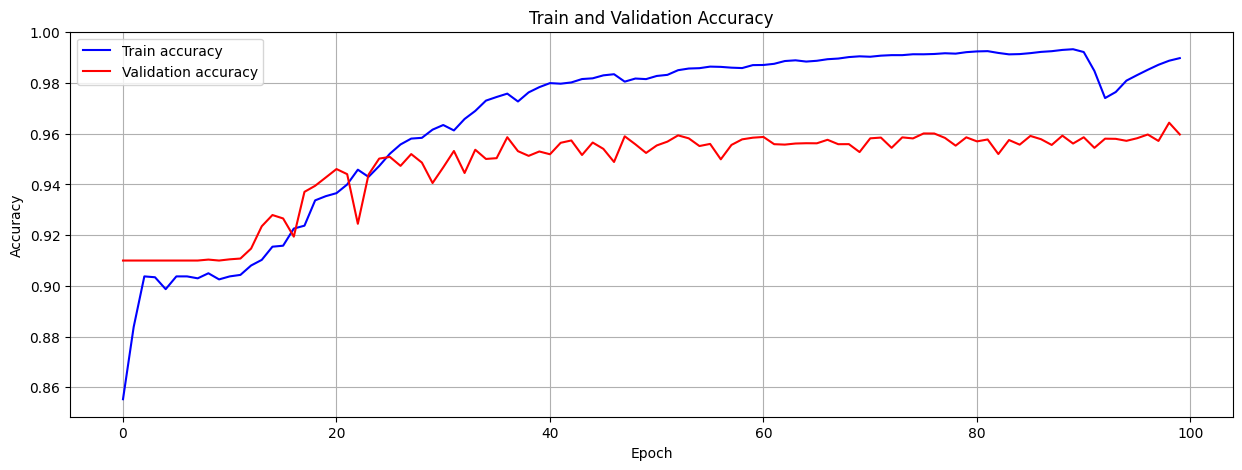

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.epoch, history.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history.epoch, history.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Chart analize:


1. **Overfitting:**
   - There is a noticeable gap between training accuracy and validation accuracy, particularly after 40 epochs. The training accuracy reaches nearly 99%, while the validation accuracy remains around 96%. This gap suggests some level of overfitting, where the model performs better on training data than on validation data.

2. **Model Generalization:**
   - Despite the overfitting, the validation accuracy is relatively high and stable, indicating that the model generalizes well to new data within this domain.

3. **Convergence:**
   - Both training and validation accuracies show convergence, with training accuracy approaching 100% and validation accuracy stabilizing around 96%. This indicates that the model has reached its optimal performance given the current architecture and data.

What can i change in the model?
To address the overfitting, consider implementing regularization techniques such as dropout, L2 regularization, or data augmentation. This can help improve the model's generalization to unseen data. Implementing early stopping based on validation accuracy could prevent overfitting. This would stop the training when the validation accuracy stops improving for a specified number of epochs. Employing cross-validation can provide a more robust estimate of the model's performance and ensure that it generalizes well across different subsets of the data.

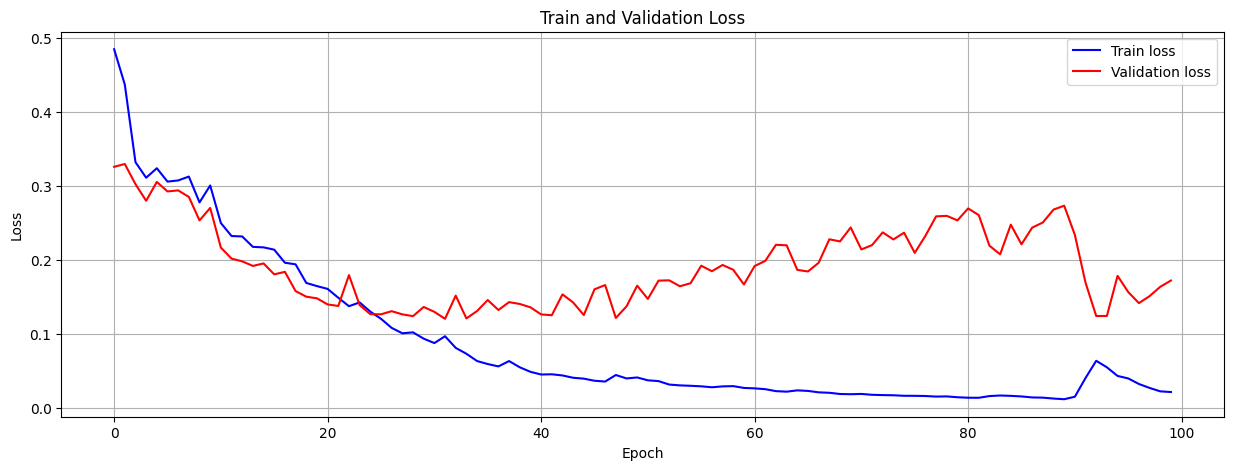

In [ ]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history.epoch, history.history['loss'], label="Train loss", color='blue')
plt.plot(history.epoch, history.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Chart analize:

1. **Overfitting:**
   - The increasing gap between training loss and validation loss as training progresses indicates overfitting. The training loss continues to decrease while the validation loss fluctuates and does not show a corresponding decrease.
   - The large fluctuations in validation loss in the later epochs further reinforce the possibility of overfitting, as the model's performance on validation data becomes less predictable.

2. **Model Convergence:**
   - The training loss shows good convergence, reaching a low and stable value. However, the validation loss does not converge as well, highlighting issues with the model's generalization.

3. **Validation Loss Fluctuations:**
   - The validation loss fluctuations suggest that the model may be sensitive to certain patterns or noise in the validation set. This could indicate that the model is overfitting to specific details in the training data that do not generalize well.

What can I change?

1. **Regularization:**
   - Implement regularization techniques such as dropout, L2 regularization, or early stopping to reduce overfitting. These techniques can help the model generalize better to unseen data.

2. **Data Augmentation:**
   - Use data augmentation to artificially increase the diversity of the training data. This can help the model learn more robust features and improve generalization.

In [ ]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()

print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

print(history_df)

Highest Accuracy: 0.9932994246482849
Lowest Loss: 0.012286579236388206
        loss  accuracy  val_loss  val_accuracy  epoch
0   0.484720  0.855300  0.326003      0.909979      0
1   0.437081  0.883764  0.329794      0.909979      1
2   0.332279  0.903730  0.302582      0.909979      2
3   0.311267  0.903387  0.280125      0.909979      3
4   0.324067  0.898696  0.305629      0.909979      4
..       ...       ...       ...           ...    ...
95  0.040362  0.983099  0.156978      0.958203     95
96  0.032835  0.985192  0.142004      0.959674     96
97  0.027523  0.987162  0.151480      0.957138     97
98  0.022913  0.988768  0.164038      0.964328     98
99  0.021994  0.989792  0.172522      0.959693     99

[100 rows x 5 columns]


In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.78683656
Precision Score = 0.700
Recall Score = 0.834
F1 Score = 0.761


In [ ]:
import pandas as pd
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

history_df = pd.DataFrame({
    'epoch': history.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history.epoch)  # Adding F1 score to all rows
})

csv_file_path = '/content/drive/MyDrive/training_log_1.csv'

history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_1.csv


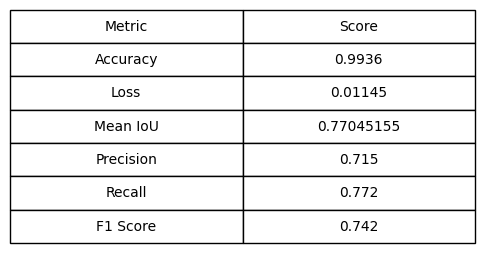

In [ ]:
import pandas as pd

# Provided metrics
Highest_Accuracy= 0.9936
Lowest_Loss= 0.01145
mean_iou = 0.77045155
precision = 0.715
recall = 0.772
f1_score = 0.742

# Creating a DataFrame for displaying the results in a table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss','Mean IoU', 'Precision', 'Recall', 'F1 Score'],
    'Score': [Highest_Accuracy, Lowest_Loss, mean_iou, precision, recall, f1_score]
})

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Display the DataFrame
fig, ax = plt.subplots(figsize=(6, 2))  # Set figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.scale(1, 2)  # Scale table to make it more readable

plt.show()


Table analize:

1. **Accuracy: 0.9936**
   - This indicates that the model correctly classifies 99.36% of the examples. This is a very high accuracy, suggesting that the model performs well on the given dataset.

2. **Loss: 0.01145**
   - The loss value is very low, which is a good indicator of the model's performance. A lower loss value generally indicates better model predictions.

3. **Mean IoU: 0.77045155**
   - The Mean Intersection over Union (IoU) is 77.04%. IoU is a metric used for evaluating the accuracy of object detection and segmentation tasks. This value indicates that there is a good overlap between the predicted and actual masks, but there might be room for improvement.

4. **Precision: 0.715**
   - Precision is 71.5%, which indicates that when the model predicts a positive class, it is correct 71.5% of the time. This shows that there might be some false positives that need to be addressed.

5. **Recall: 0.772**
   - Recall is 77.2%, indicating that the model is able to identify 77.2% of the actual positive cases. This suggests that the model might be missing some positives (false negatives).

6. **F1 Score: 0.742**
   - The F1 Score, which is the harmonic mean of Precision and Recall, is 74.2%. This value balances precision and recall, providing a single metric that considers both false positives and false negatives.

The model shows high accuracy and low loss, indicating good overall performance. The Mean IoU is quite good, showing that the model performs well in terms of overlap in segmentation tasks, but there might be room for improvement. Precision and recall values suggest that the model performs well but can be improved to reduce false positives and false negatives. The F1 Score provides a balanced view, indicating the model's performance considering both precision and recall.

What can I change?
- **Improve Precision and Recall:** Work on reducing false positives and false negatives by possibly fine-tuning the model, adding more training data, or using different model architectures.
- **Monitor Overfitting:** Given the high accuracy and low loss, ensure the model is not overfitting by evaluating it on a separate validation or test set.
- **Hyperparameter Tuning:** Experiment with different hyperparameters to see if the Mean IoU and F1 Score can be improved further.

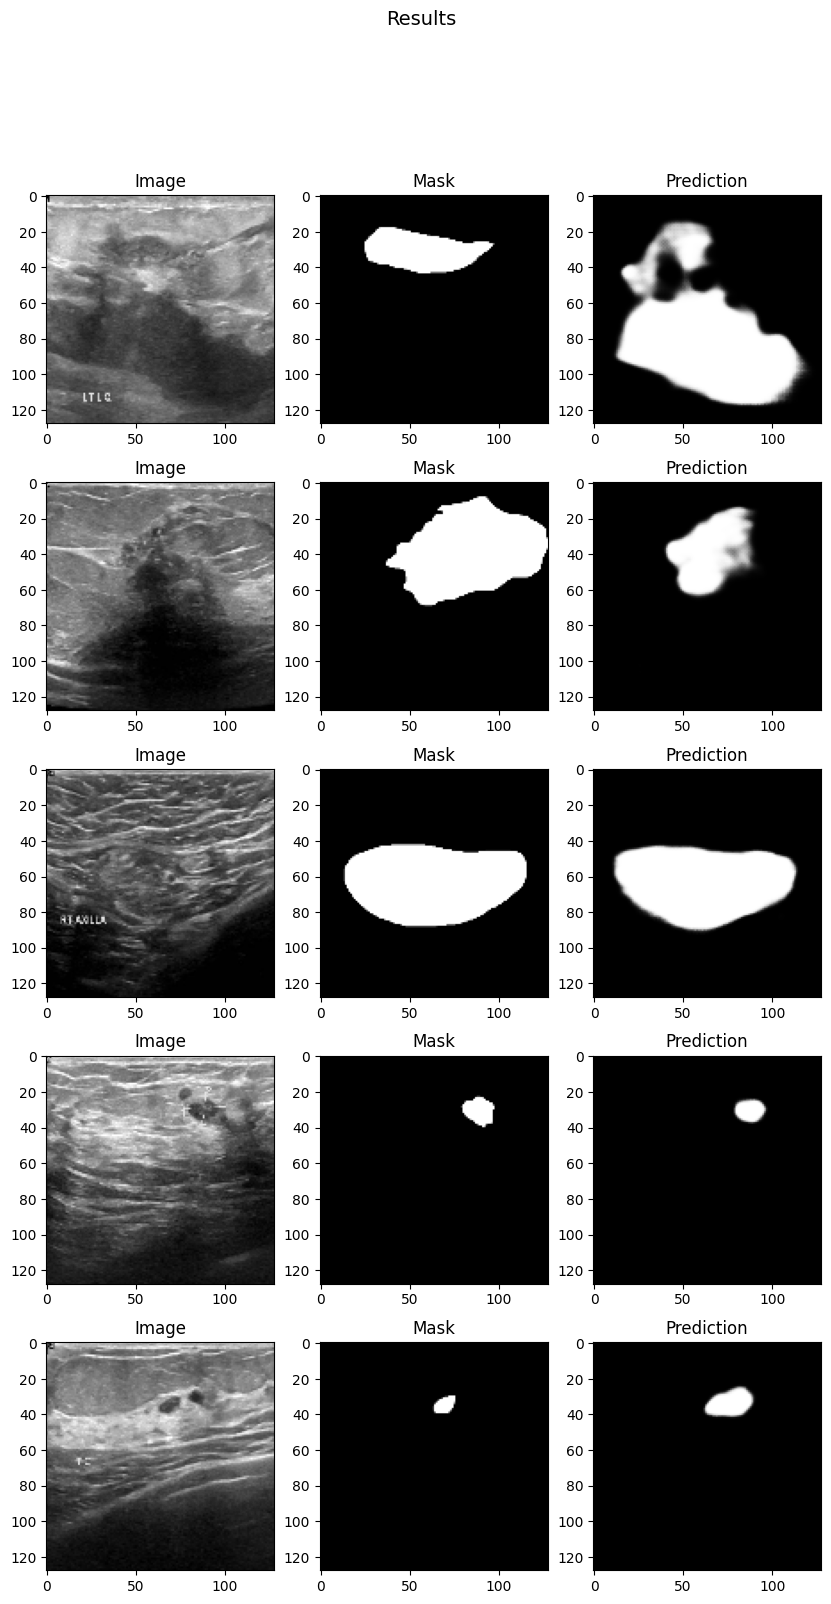

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=14)
plt.show()

 The model's prediction covers a similar area as the ground truth mask, but it appears somewhat blurry and less precise. There are false positive regions where the prediction extends beyond the actual lesion. The prediction is quite accurate, closely matching the shape and size of the ground truth mask. The edges are slightly blurred but overall the prediction is satisfactory. Similar to the second row, the prediction aligns well with the mask, though the edges are not as sharply defined. The model has successfully identified the lesion, but the prediction is slightly larger and less defined compared to the ground truth mask. The prediction again covers the region of interest, but it shows some blurriness and slight over-prediction.
Across all examples, the predictions tend to be less defined and slightly blurred compared to the ground truth masks. This could be due to the model's output being smoothed or the use of post-processing techniques. In some cases, the model predicts regions larger than the actual lesions, indicating areas where the model is less certain or misidentifying normal tissue as abnormal.

#**Moled - FCN**

What has been adjusted?
1. Added layers for encoding (downsampling) and decoding (upsampling).
2. Added connections using the "concatenate" option to connect feature maps from encoder to decoder.
3. Bottleneck layer representing dense objects.
4. Filters added - Each layer has many filters, and the network gradually increases the number of filters.

It uses a more complex encoder-decoder structure with four down-sampling layers and four up-sampling layers. It includes skip joins ("pooling") to combine feature maps from the encoder to the decoder, preserving spatial information. It gradually increases the number of filters to 1024 in the bottleneck layer. It contains a bottleneck layer with 1024 filters, and has a larger number of upsampling layers.

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def fcn_model(input_shape):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)

    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (size, size, 1)
fcn = fcn_model(input_shape)
fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


fcn.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 128, 128, 64)         640       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_11[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 64, 64, 128)          73856     ['max_pooling2d_2[0][0]'

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 128, 128, 64)         640       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_11[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 64, 64, 128)          73856     ['max_pooling2d_2[0][0]'

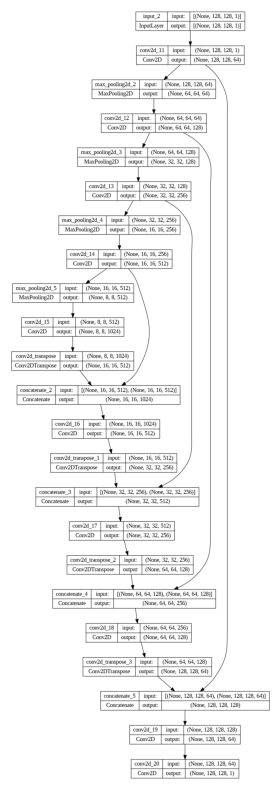

In [60]:
fcn.summary()

# Plot the model architecture
plot_model(fcn, to_file='fcn_model.png', show_shapes=True, show_layer_names=True)

# Display the plot (requires matplotlib)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('fcn_model.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:

input_shape = (size, size, 1)
fcn = fcn_model(input_shape)

fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history3 = fcn.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
19/19 [==============================] - 10s 273ms/step - loss: 0.5499 - accuracy: 0.8899 - val_loss: 0.3269 - val_accuracy: 0.9100
Epoch 2/100
19/19 [==============================] - 4s 219ms/step - loss: 0.2896 - accuracy: 0.9037 - val_loss: 0.2407 - val_accuracy: 0.9100
Epoch 3/100
19/19 [==============================] - 4s 227ms/step - loss: 0.2537 - accuracy: 0.9042 - val_loss: 0.2282 - val_accuracy: 0.9100
Epoch 4/100
19/19 [==============================] - 5s 240ms/step - loss: 0.2355 - accuracy: 0.9046 - val_loss: 0.2053 - val_accuracy: 0.9108
Epoch 5/100
19/19 [==============================] - 4s 222ms/step - loss: 0.2286 - accuracy: 0.9108 - val_loss: 0.2009 - val_accuracy: 0.9231
Epoch 6/100
19/19 [==============================] - 4s 226ms/step - loss: 0.2171 - accuracy: 0.9158 - val_loss: 0.2116 - val_accuracy: 0.9152
Epoch 7/100
19/19 [==============================] - 4s 233ms/step - loss: 0.2218 - accuracy: 0.9142 - val_loss: 0.1894 - val_accuracy: 0.928

In [ ]:
import pandas as pd
accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

history_df = pd.DataFrame({
    'epoch': history.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history3.epoch),
    'precision': [prec_score] * len(history3.epoch),
    'recall': [recall_score] * len(history3.epoch),
    'f1_score': [f1_score] * len(history3.epoch)
})

csv_file_path = '/content/drive/MyDrive/training_log_3.csv'
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_3.csv


In [45]:
import pandas as pd

In [ ]:
history_df = pd.DataFrame(history3.history)
history_df['epoch'] = history3.epoch

max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()

print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

print(history_df)

Highest Accuracy: 0.9957878589630127
Lowest Loss: 0.0061830016784369946
        loss  accuracy  val_loss  val_accuracy  epoch
0   0.549910  0.889931  0.326905      0.909979      0
1   0.289582  0.903730  0.240711      0.909979      1
2   0.253682  0.904185  0.228152      0.909979      2
3   0.235464  0.904615  0.205273      0.910797      3
4   0.228611  0.910792  0.200867      0.923141      4
..       ...       ...       ...           ...    ...
95  0.007034  0.995477  0.427998      0.958412     95
96  0.006598  0.995621  0.418426      0.959018     96
97  0.006768  0.995582  0.420189      0.958237     97
98  0.006616  0.995634  0.429594      0.958351     98
99  0.006183  0.995788  0.432994      0.958792     99

[100 rows x 5 columns]


In [ ]:
y_pred=fcn.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.7888366
Precision Score = 0.734
Recall Score = 0.800
F1 Score = 0.766


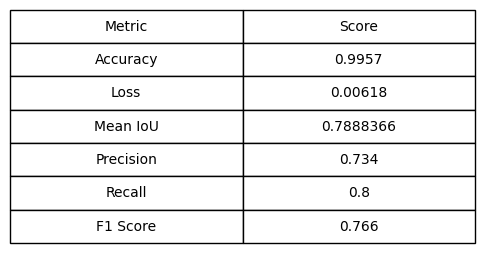

In [ ]:
import pandas as pd

# Provided metrics
Highest_Accuracy= 0.9957
Lowest_Loss= 0.00618
mean_iou = 0.7888366
precision = 0.734
recall = 0.800
f1_score = 0.766

# Creating a DataFrame for displaying the results in a table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss','Mean IoU', 'Precision', 'Recall', 'F1 Score'],
    'Score': [Highest_Accuracy, Lowest_Loss, mean_iou, precision, recall, f1_score]
})

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Display the DataFrame
fig, ax = plt.subplots(figsize=(6, 2))  # Set figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.scale(1, 2)  # Scale table to make it more readable

plt.show()


Table analize:

1. **Accuracy: 0.9957**
   - The model's accuracy is very high, indicating that it correctly classifies the vast majority of the pixels in the segmentation task. However, accuracy alone can be misleading in imbalanced datasets, so other metrics are also important to consider.

2. **Loss: 0.00618**
   - The low loss value indicates that the model's predictions are very close to the actual values. This suggests that the model is well-trained and has minimized the error during training.

3. **Mean IoU (Intersection over Union): 0.7888366**
   - Mean IoU is a common metric for evaluating segmentation models. A Mean IoU of approximately 0.79 indicates that the model's predicted segmentation masks overlap well with the true masks, but there is still some room for improvement to achieve even higher overlap.

4. **Precision: 0.734**
   - Precision indicates the proportion of true positive predictions among all positive predictions. A precision of 0.734 means that 73.4% of the pixels predicted as part of the lesion are actually part of the lesion. This metric reflects the model's ability to avoid false positives.

5. **Recall: 0.8**
   - Recall measures the proportion of true positive predictions among all actual positives. A recall of 0.8 means that the model correctly identifies 80% of the actual lesion pixels. This metric reflects the model's ability to detect the lesion pixels, minimizing false negatives.

6. **F1 Score: 0.766**
   - The F1 score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance. An F1 score of 0.766 indicates that the model has a good balance between precision and recall, performing well in both detecting lesions and avoiding false positives.

The model shows high accuracy and low loss, indicating overall strong performance in the segmentation task. The precision and recall values are relatively balanced, with recall being slightly higher. This suggests that the model is somewhat better at detecting lesion pixels than avoiding false positives. The Mean IoU score is good but not perfect, indicating that while the model's segmentation masks overlap well with the true masks, there is still room for improvement. The F1 score confirms that the model has a balanced performance, taking into account both precision and recall.

##FCN Model training with early stopping
(38 epochs)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)


fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history13 = fcn.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/100
19/19 [==============================] - 24s 476ms/step - loss: 0.5209 - accuracy: 0.8592 - val_loss: 0.3161 - val_accuracy: 0.9124
Epoch 2/100
19/19 [==============================] - 4s 202ms/step - loss: 0.3257 - accuracy: 0.9035 - val_loss: 0.2506 - val_accuracy: 0.9124
Epoch 3/100
19/19 [==============================] - 4s 204ms/step - loss: 0.2894 - accuracy: 0.9035 - val_loss: 0.2194 - val_accuracy: 0.9131
Epoch 4/100
19/19 [==============================] - 4s 205ms/step - loss: 0.2530 - accuracy: 0.9037 - val_loss: 0.2030 - val_accuracy: 0.9124
Epoch 5/100
19/19 [==============================] - 4s 201ms/step - loss: 0.2391 - accuracy: 0.9046 - val_loss: 0.2064 - val_accuracy: 0.9243
Epoch 6/100
19/19 [==============================] - 4s 204ms/step - loss: 0.2320 - accuracy: 0.9053 - val_loss: 0.1918 - val_accuracy: 0.9175
Epoch 7/100
19/19 [==============================] - 4s 207ms/step - loss: 0.2247 - accuracy: 0.9135 - val_loss: 0.1723 - val_accuracy: 0.931

In [44]:
import pandas as pd
accuracy = history13.history['accuracy']
val_accuracy = history13.history['val_accuracy']
loss = history13.history['loss']
val_loss = history13.history['val_loss']

history_df = pd.DataFrame({
    'epoch': history13.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history13.epoch),
    'precision': [prec_score] * len(history13.epoch),
    'recall': [recall_score] * len(history13.epoch),
    'f1_score': [f1_score] * len(history13.epoch)
})

csv_file_path = '/content/drive/MyDrive/training_log_13.csv'
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_13.csv


In [46]:
history_df = pd.DataFrame(history13.history)
history_df['epoch'] = history13.epoch

max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()

print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

print(history_df)

Highest Accuracy: 0.9758010506629944
Lowest Loss: 0.05833474546670914
        loss  accuracy  val_loss  val_accuracy  epoch
0   0.520946  0.859241  0.316148      0.912444      0
1   0.325655  0.903455  0.250646      0.912444      1
2   0.289397  0.903455  0.219395      0.913130      2
3   0.252973  0.903665  0.202990      0.912444      3
4   0.239066  0.904650  0.206445      0.924267      4
5   0.232006  0.905341  0.191809      0.917523      5
6   0.224750  0.913471  0.172347      0.931105      6
7   0.207313  0.919278  0.157583      0.938575      7
8   0.195358  0.926523  0.150729      0.939750      8
9   0.191874  0.927115  0.215378      0.905429      9
10  0.195167  0.923932  0.143986      0.944232     10
11  0.184624  0.931033  0.142879      0.943112     11
12  0.185204  0.929313  0.152303      0.941117     12
13  0.177762  0.932354  0.129434      0.947221     13
14  0.157969  0.940015  0.141423      0.942015     14
15  0.155615  0.941562  0.122714      0.952379     15
16  0.143254

In [47]:
y_pred=fcn.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.7469448
Precision Score = 0.643
Recall Score = 0.771
F1 Score = 0.701


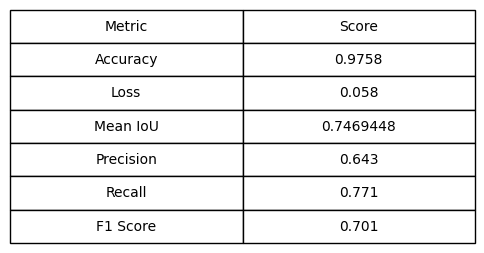

In [48]:
import pandas as pd

# Provided metrics
Highest_Accuracy= 0.9758
Lowest_Loss= 0.058
mean_iou = 0.7469448
precision = 0.643
recall = 0.771
f1_score = 0.701

# Creating a DataFrame for displaying the results in a table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss','Mean IoU', 'Precision', 'Recall', 'F1 Score'],
    'Score': [Highest_Accuracy, Lowest_Loss, mean_iou, precision, recall, f1_score]
})

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Display the DataFrame
fig, ax = plt.subplots(figsize=(6, 2))  # Set figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.scale(1, 2)  # Scale table to make it more readable

plt.show()


Table analize:

- **High Accuracy**: The high accuracy suggests that the model is performing well overall in terms of classification.
- **Low Loss**: The low loss value indicates that the model is effectively minimizing the error in its predictions.
- **Good Mean IoU**: A Mean IoU of approximately 0.75 is indicative of good performance in segmentation tasks, reflecting that the predicted segments overlap well with the ground truth.
- **Precision and Recall**: The precision is slightly lower than recall, indicating that while the model is good at identifying most of the positive instances (high recall), there are some false positives (lower precision).
- **Balanced F1 Score**: The F1 score suggests a balanced performance, taking both precision and recall into account.

To improve precision, the model might need to reduce the number of false positives. This can be achieved through techniques like threshold adjustment, more representative training data, or tuning the model’s complexity.



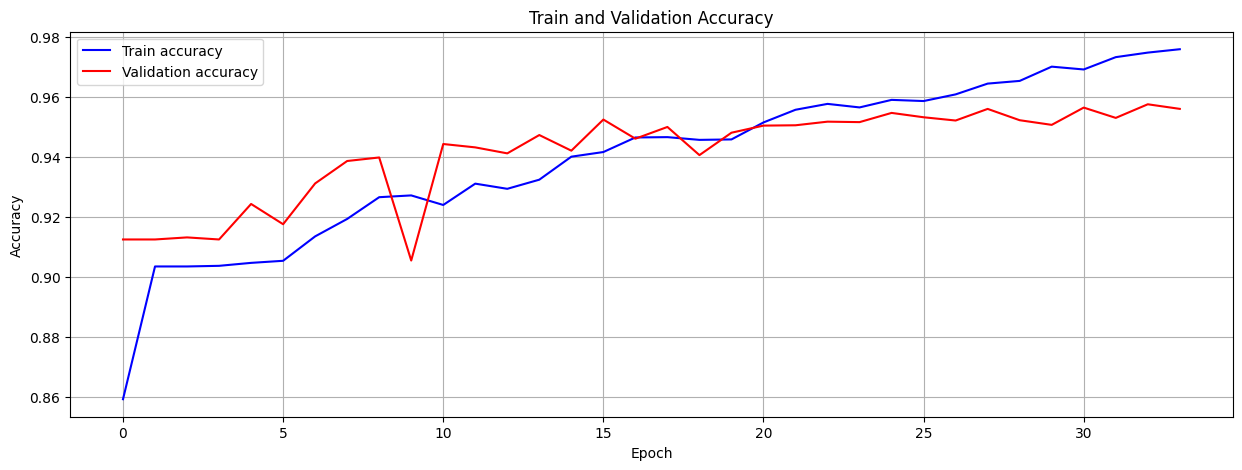

In [49]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history13.epoch, history13.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history13.epoch, history13.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Both training and validation accuracy improve over time, indicating that the model is learning and generalizing well. The fluctuations in validation accuracy suggest that the model may be encountering varying difficulty levels within the validation set. It may also indicate potential overfitting as the model learns specific patterns in the training data that do not generalize as well to unseen data.
By the end of the training, the gap between training and validation accuracy increases slightly, suggesting the model might be starting to overfit. Training accuracy continues to increase, while validation accuracy stabilizes or slightly decreases.

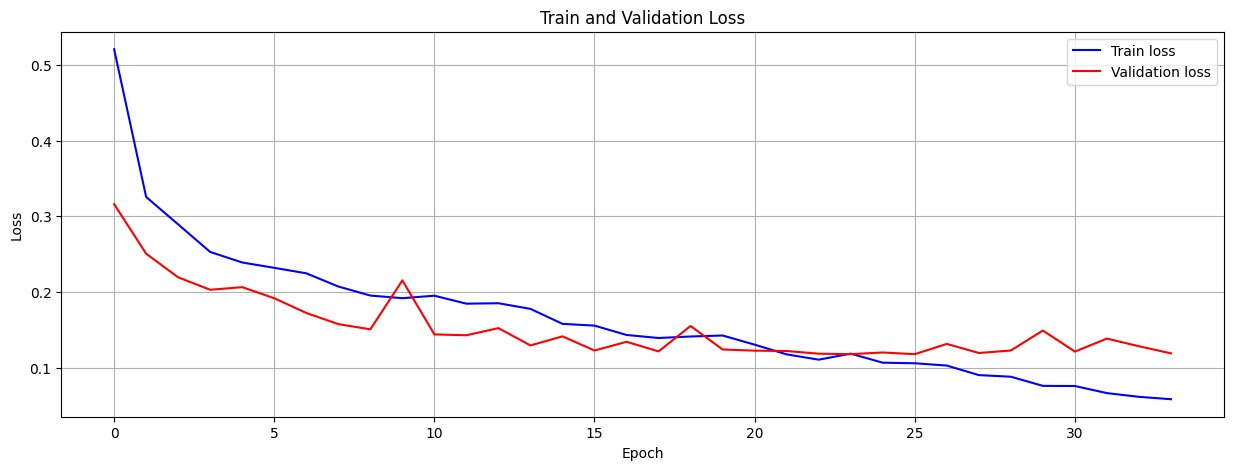

In [50]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history13.epoch, history13.history['loss'], label="Train loss", color='blue')
plt.plot(history13.epoch, history13.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Both training and validation loss decrease over time, indicating that the model is improving its performance. The fluctuations in validation loss, especially after epoch 10, suggest that the model might be encountering different levels of difficulty within the validation set. This is often a sign of the model starting to overfit to the training data. Initially, the training loss is higher than the validation loss, but they converge and cross around epoch 10, indicating that the model is learning well initially. The divergence later on suggests potential overfitting.

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.0001
)

# Assuming you have your model 'fcn' and data 'X_train', 'y_train', 'X_val', 'y_val'

history14 = fcn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
37/37 [==============================] - 10s 117ms/step - loss: 0.1101 - accuracy: 0.9580 - val_loss: 0.1354 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 4s 112ms/step - loss: 0.1097 - accuracy: 0.9585 - val_loss: 0.1213 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 4s 112ms/step - loss: 0.1025 - accuracy: 0.9606 - val_loss: 0.1127 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 4s 119ms/step - loss: 0.1026 - accuracy: 0.9606 - val_loss: 0.1096 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 4s 113ms/step - loss: 0.0928 - accuracy: 0.9637 - val_loss: 0.1231 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 4s 112ms/step - loss: 0.0812 - accuracy: 0.9677 - val_loss: 0.1409 - val_accuracy: 0.9566 - lr: 0.0010
Epoch 7/100
37/37 [==============================] - 4s 112ms/s

In [53]:
import pandas as pd
accuracy = history14.history['accuracy']
val_accuracy = history14.history['val_accuracy']
loss = history14.history['loss']
val_loss = history14.history['val_loss']

history_df = pd.DataFrame({
    'epoch': history14.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history14.epoch),
    'precision': [prec_score] * len(history14.epoch),
    'recall': [recall_score] * len(history14.epoch),
    'f1_score': [f1_score] * len(history14.epoch)
})

csv_file_path = '/content/drive/MyDrive/training_log_14.csv'
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_14.csv


In [54]:
history_df = pd.DataFrame(history14.history)
history_df['epoch'] = history14.epoch

max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()

print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

print(history_df)

Highest Accuracy: 0.9829403758049011
Lowest Loss: 0.038708291947841644
        loss  accuracy  val_loss  val_accuracy      lr  epoch
0   0.110113  0.957998  0.135411      0.950928  0.0010      0
1   0.109664  0.958478  0.121348      0.950960  0.0010      1
2   0.102486  0.960636  0.112692      0.954295  0.0010      2
3   0.102637  0.960631  0.109596      0.954813  0.0010      3
4   0.092774  0.963678  0.123119      0.950988  0.0010      4
5   0.081205  0.967727  0.140919      0.956648  0.0010      5
6   0.075852  0.969918  0.126596      0.952830  0.0010      6
7   0.070405  0.971832  0.125574      0.955056  0.0010      7
8   0.065812  0.973422  0.123005      0.956720  0.0010      8
9   0.052187  0.978159  0.137572      0.955583  0.0002      9
10  0.045650  0.980387  0.137497      0.956663  0.0002     10
11  0.042730  0.981536  0.145493      0.957274  0.0002     11
12  0.041416  0.981933  0.144668      0.956954  0.0002     12
13  0.038708  0.982940  0.150232      0.956233  0.0002     13

In [55]:
y_pred=fcn.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.74920225
Precision Score = 0.596
Recall Score = 0.849
F1 Score = 0.701


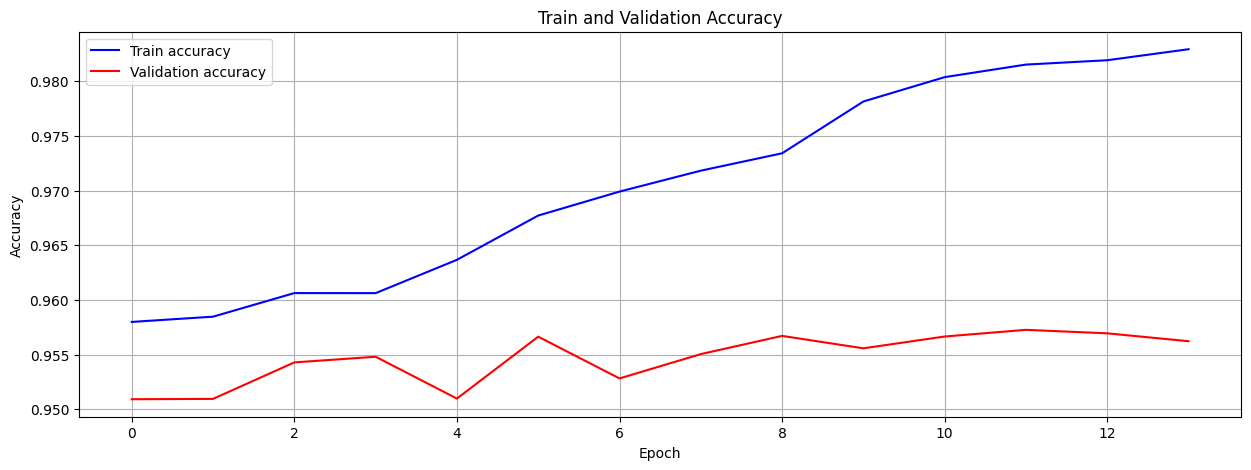

In [56]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history14.epoch, history14.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history14.epoch, history14.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

The training accuracy improves steadily, indicating that the model is learning and optimizing its performance on the training data.
The validation accuracy remains high but shows some fluctuations, indicating variability in generalization performance.

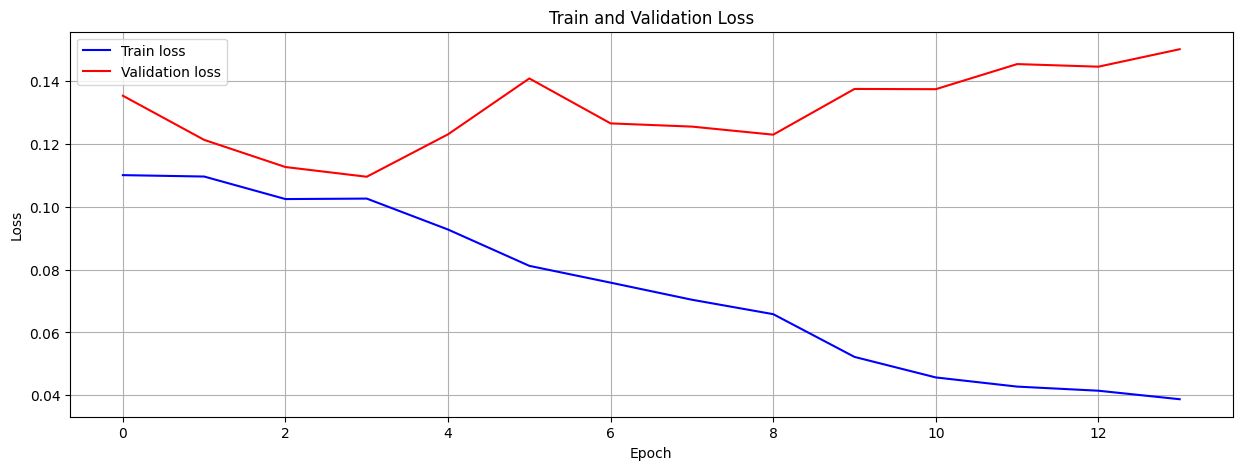

In [57]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history14.epoch, history14.history['loss'], label="Train loss", color='blue')
plt.plot(history14.epoch, history14.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = '1', lab2 = '2'):
    plt.clf()
    plt.rcParams['figure.figsize'] = (25.0, 10.0)
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies for U-net and FCN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

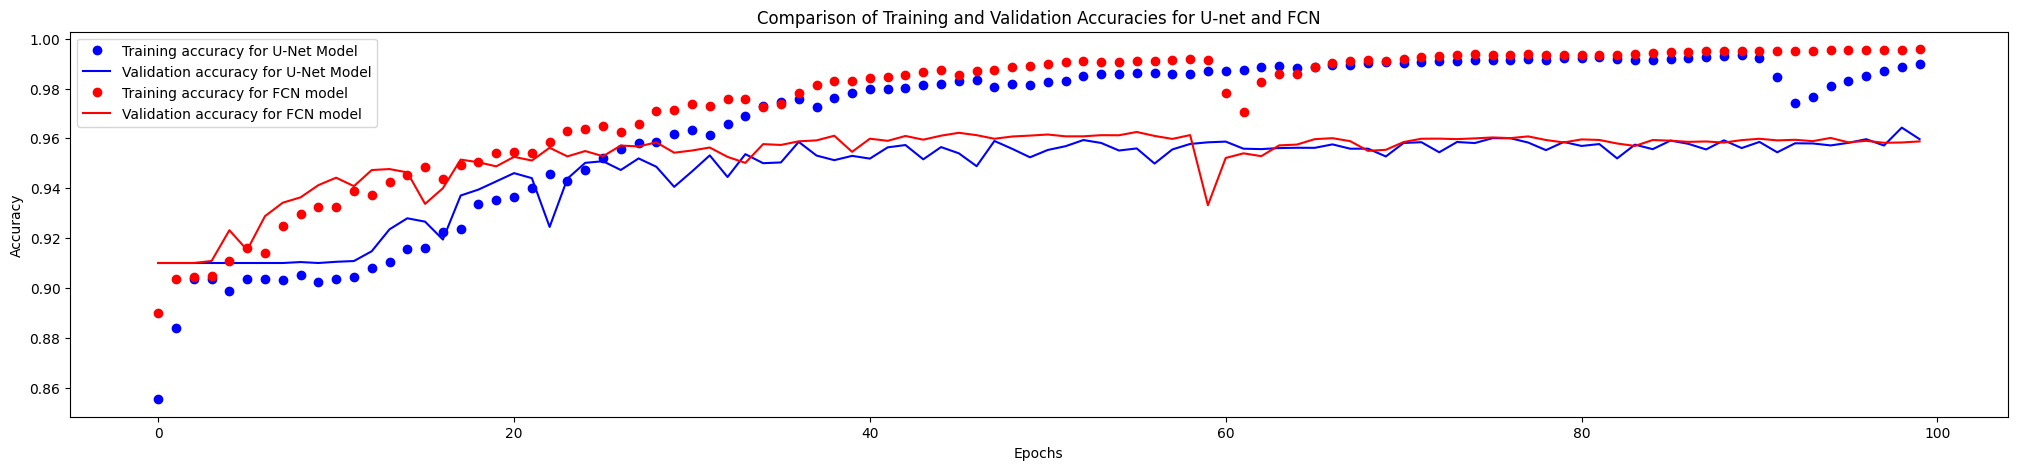

In [ ]:

acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
acc2 = history3.history['accuracy']
val_acc2 = history3.history['val_accuracy']


PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, 'U-Net Model', 'FCN model')

Chart analize

1. **Accuracy Comparison:**
   - **Training Accuracy:**
     - The FCN model achieves higher training accuracy faster than the U-Net model and maintains a slightly higher accuracy throughout the training.
   - **Validation Accuracy:**
     - The FCN model consistently shows better validation accuracy compared to the U-Net model, indicating better generalization performance.

2. **Model Stability:**
   - **U-Net Model:** Shows more fluctuations in both training and validation accuracy, suggesting it may be more sensitive to variations in the data or may require more epochs to stabilize.
   - **FCN Model:** Exhibits more stable performance with less fluctuation, indicating robust learning and generalization.

3. **Overfitting:**
   - Both models show high training accuracies, but the U-Net model has a slightly lower validation accuracy, indicating it might be overfitting more compared to the FCN model.

Based on the provided accuracy metrics, the FCN model appears to perform better overall, with higher validation accuracy and more stability. It may be the preferred choice for this specific task. For the U-Net model, applying additional regularization techniques such as dropout or weight decay might help improve its validation performance and reduce fluctuations.

In [ ]:
import matplotlib.pyplot as plt

def PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = '1', lab2 = '2'):
    plt.clf()
    plt.rcParams['figure.figsize'] = (25.0, 4.0)
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses for for U-net and FCN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

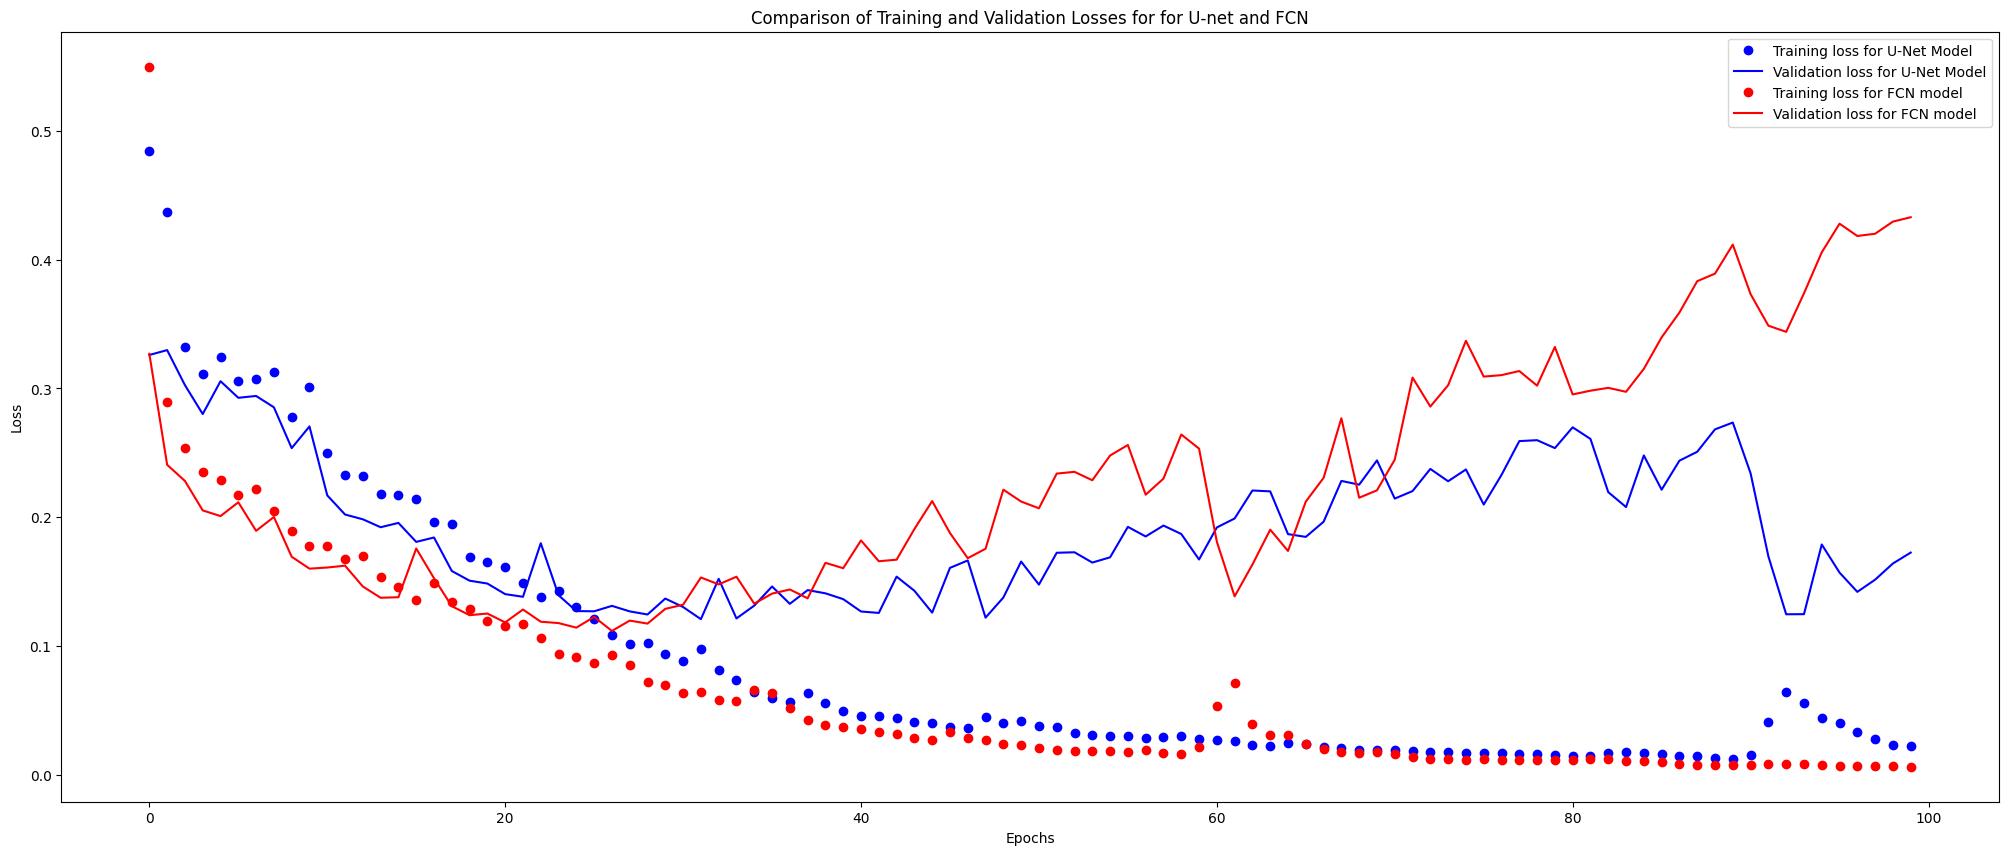

In [ ]:

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
loss2 = history3.history['loss']
val_loss2 = history3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, 'U-Net Model', 'FCN model')

Chart analize:

1. **Loss Comparison:**
   - **Training Loss:**
     - Both models show a similar pattern of rapid decrease in training loss, stabilizing at a low value. The FCN model's training loss decreases more smoothly compared to the U-Net model.
   - **Validation Loss:**
     - The FCN model consistently shows lower validation loss compared to the U-Net model, indicating better generalization performance and less overfitting.

2. **Model Stability:**
   - **U-Net Model:** Shows more fluctuations in validation loss, indicating that it may be more sensitive to variations in the validation data or overfitting to the training data.
   - **FCN Model:** Exhibits more stable performance with fewer fluctuations in validation loss, suggesting robust learning and better generalization.

3. **Overfitting:**
   - The U-Net model shows significant fluctuations in validation loss, especially in the later epochs, suggesting overfitting. In contrast, the FCN model, despite some fluctuations, maintains lower and more stable validation loss.

The FCN model appears to perform better overall in terms of both training and validation loss, indicating better generalization and stability.

##Segnet model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def segnet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5)

    # Decoder
    up6 = UpSampling2D((2, 2))(pool5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D((2, 2))(conv7)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D((2, 2))(conv8)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    up10 = UpSampling2D((2, 2))(conv9)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (size, size, 1)
segnet = segnet_model(input_shape)
segnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

segnet.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_40 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 128)       147584    
                                                           

In [ ]:

history4 = segnet.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
19/19 [==============================] - 6s 336ms/step - loss: 0.3341 - accuracy: 0.9037 - val_loss: 0.2969 - val_accuracy: 0.9100
Epoch 2/100
19/19 [==============================] - 6s 298ms/step - loss: 0.3175 - accuracy: 0.9037 - val_loss: 0.2843 - val_accuracy: 0.9100
Epoch 3/100
19/19 [==============================] - 6s 293ms/step - loss: 0.2768 - accuracy: 0.9037 - val_loss: 0.2676 - val_accuracy: 0.9100
Epoch 4/100
19/19 [==============================] - 5s 287ms/step - loss: 0.2754 - accuracy: 0.9037 - val_loss: 0.2363 - val_accuracy: 0.9100
Epoch 5/100
19/19 [==============================] - 6s 292ms/step - loss: 0.2652 - accuracy: 0.9037 - val_loss: 0.2473 - val_accuracy: 0.9100
Epoch 6/100
19/19 [==============================] - 6s 293ms/step - loss: 0.2639 - accuracy: 0.9037 - val_loss: 0.2446 - val_accuracy: 0.9100
Epoch 7/100
19/19 [==============================] - 6s 291ms/step - loss: 0.2580 - accuracy: 0.9037 - val_loss: 0.2361 - val_accuracy: 0.9100

In [ ]:
import pandas as pd
# Extract accuracy and loss values from the history object
accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Create a DataFrame to store the values
history_df = pd.DataFrame({
    'epoch': history.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history4.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history4.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history4.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history4.epoch)  # Adding F1 score to all rows
})

# Define the path to save the CSV file (adjust the path as needed)
csv_file_path = '/content/drive/MyDrive/training_log_4.csv'

# Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_4.csv


In [ ]:
history_df = pd.DataFrame(history4.history)
history_df['epoch'] = history4.epoch

# Extract the highest accuracy and the lowest loss value
max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()


print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

# Optionally, display the DataFrame
print(history_df)

Highest Accuracy: 0.9831493496894836
Lowest Loss: 0.037232693284749985
        loss  accuracy  val_loss  val_accuracy  epoch
0   0.334122  0.903730  0.296900      0.909979      0
1   0.317509  0.903730  0.284330      0.909979      1
2   0.276835  0.903730  0.267640      0.909979      2
3   0.275429  0.903730  0.236328      0.909979      3
4   0.265170  0.903730  0.247322      0.909979      4
..       ...       ...       ...           ...    ...
95  0.040270  0.981896  0.192096      0.949363     95
96  0.038338  0.982878  0.194545      0.949173     96
97  0.037233  0.983149  0.195249      0.950752     97
98  0.037411  0.983010  0.181385      0.950017     98
99  0.038141  0.982827  0.175291      0.951089     99

[100 rows x 5 columns]


In [ ]:
y_pred=segnet.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.7555891
Precision Score = 0.686
Recall Score = 0.755
F1 Score = 0.719


#**Pyramid**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def pyramid_pooling_module(x, bin_sizes):
    concat_list = [x]
    w, h = x.shape[1], x.shape[2]
    for bin_size in bin_sizes:
        pool_size = (w // bin_size, h // bin_size)
        pooled = MaxPooling2D(pool_size)(x)
        upsampled = UpSampling2D(size=pool_size, interpolation='bilinear')(pooled)
        concat_list.append(upsampled)
    return Concatenate()(concat_list)

def pspnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Pyramid Pooling Module
    x = pyramid_pooling_module(x, bin_sizes=[1, 2, 3, 6])

    # Decoder
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(16, 16), interpolation='bilinear')(x)

    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    outputs = Activation('sigmoid')(x)

    model = Model(inputs, outputs, name='PSPNet')
    return model

input_shape = (size, size, 1)
num_classes = 1
pspnet = pspnet_model(input_shape, num_classes)
pspnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

pspnet.summary()


Model: "PSPNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_80 (Conv2D)          (None, 128, 128, 64)         640       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_13 (Ba  (None, 128, 128, 64)         256       ['conv2d_80[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_6 (Activation)   (None, 128, 128, 64)         0         ['batch_normalization_13[

In [ ]:
history6 = pspnet.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
19/19 [==============================] - 11s 200ms/step - loss: 0.6833 - accuracy: 0.7641 - val_loss: 0.5574 - val_accuracy: 0.7247
Epoch 2/100
19/19 [==============================] - 2s 102ms/step - loss: 0.2181 - accuracy: 0.9191 - val_loss: 0.5446 - val_accuracy: 0.6615
Epoch 3/100
19/19 [==============================] - 2s 107ms/step - loss: 0.1873 - accuracy: 0.9278 - val_loss: 0.3571 - val_accuracy: 0.8338
Epoch 4/100
19/19 [==============================] - 2s 108ms/step - loss: 0.1708 - accuracy: 0.9331 - val_loss: 0.3240 - val_accuracy: 0.8421
Epoch 5/100
19/19 [==============================] - 2s 102ms/step - loss: 0.1609 - accuracy: 0.9357 - val_loss: 0.3344 - val_accuracy: 0.8357
Epoch 6/100
19/19 [==============================] - 2s 107ms/step - loss: 0.1508 - accuracy: 0.9402 - val_loss: 0.2470 - val_accuracy: 0.8963
Epoch 7/100
19/19 [==============================] - 2s 98ms/step - loss: 0.1431 - accuracy: 0.9420 - val_loss: 0.3523 - val_accuracy: 0.8204

In [ ]:
import pandas as pd
accuracy = history6.history['accuracy']
val_accuracy = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

history_df = pd.DataFrame({
    'epoch': history.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history6.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history6.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history6.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history6.epoch)  # Adding F1 score to all rows
})

csv_file_path = '/content/drive/MyDrive/training_log_6.csv'

# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_6.csv


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode, 1 = progress messages
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with the EarlyStopping callback
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add the callback here
)


In [ ]:
y_pred=pspnet.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.6402081
Precision Score = 0.338
Recall Score = 0.985
F1 Score = 0.503


Models Comparision

In [ ]:
import matplotlib.pyplot as plt

def PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, acc4, val_acc4, lab1 = '1', lab2 = '2', lab3 = '3', lab4 = '4'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 10.0) # set default size of plots
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.plot(epochs, acc3, 'co', label='Training accuracy for ' + lab3)
    plt.plot(epochs, val_acc3, 'c', label='Validation accuracy for ' + lab3)
    plt.plot(epochs, acc4, 'go', label='Training accuracy for ' + lab4)
    plt.plot(epochs, val_acc4, 'g', label='Validation accuracy for ' + lab4)
    plt.title('Comparison of Training and Validation Accuracies for U-net and FCN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

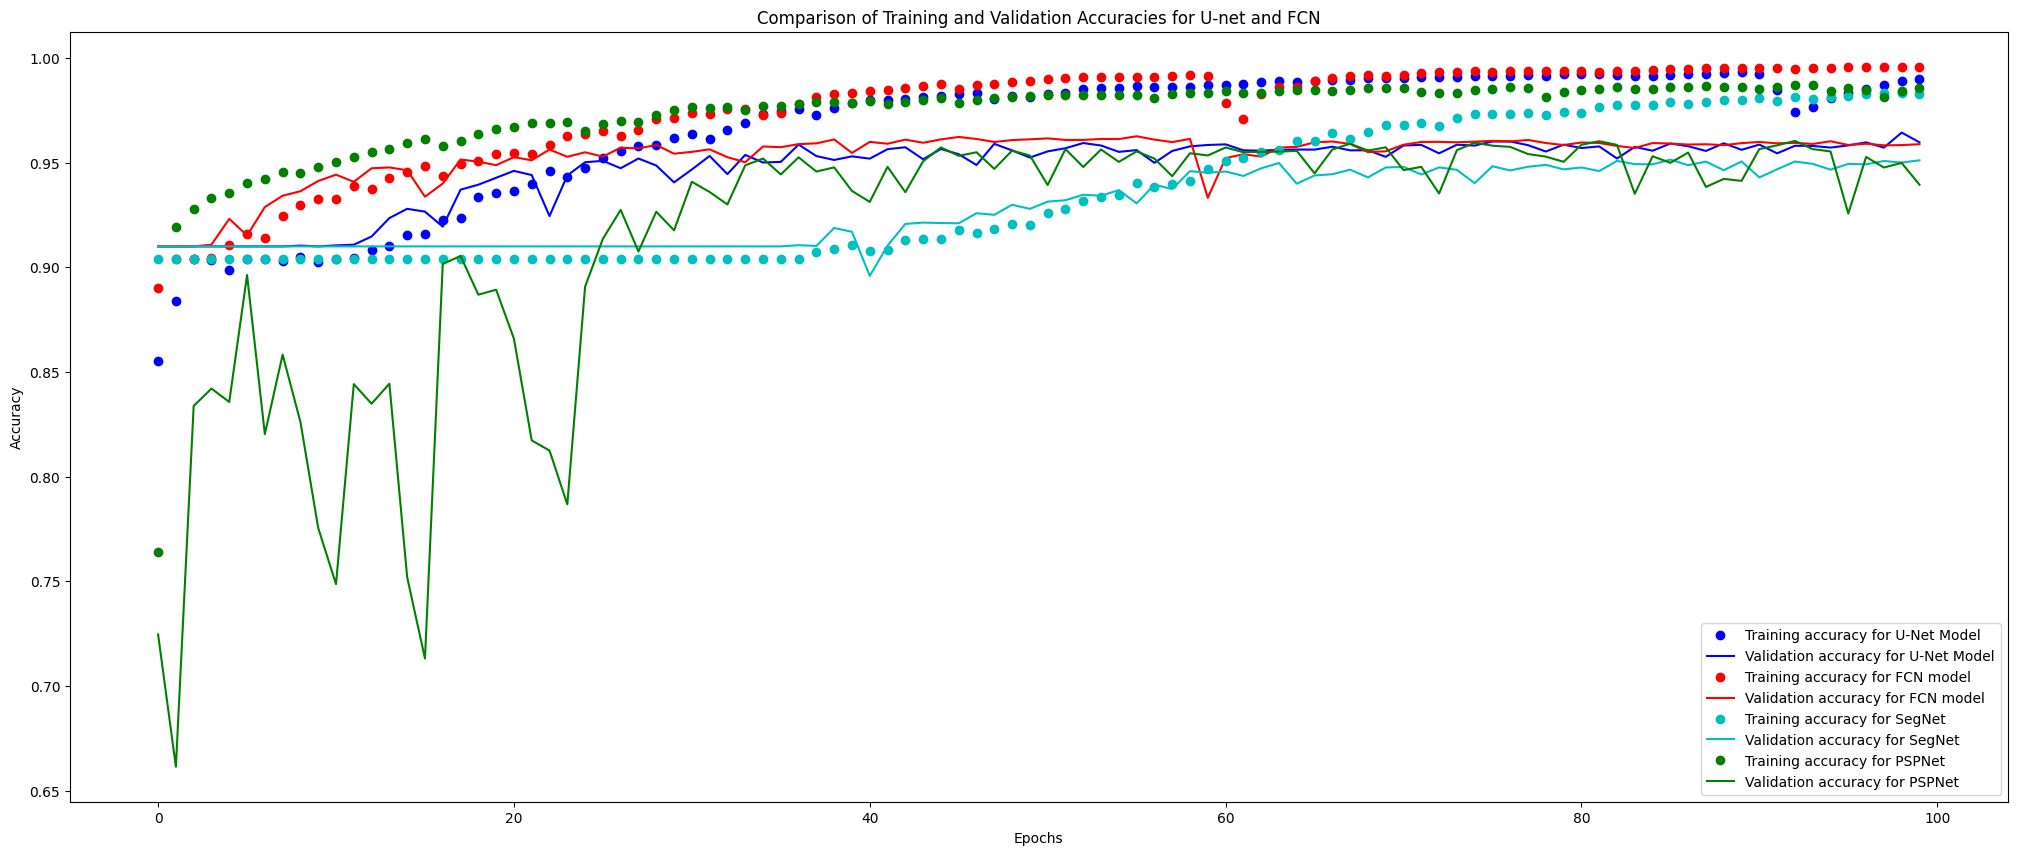

In [ ]:
# Compare the accuracies of three training processes
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
acc2 = history3.history['accuracy']
val_acc2 = history3.history['val_accuracy']
acc3 = history4.history['accuracy']
val_acc3 = history4.history['val_accuracy']
acc4 = history6.history['accuracy']
val_acc4 = history6.history['val_accuracy']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, acc4, val_acc4, 'U-Net Model', 'FCN model', 'SegNet', 'PSPNet')

Chaty analize:

1. **U-Net Model**:
   - The training loss (blue dots) and validation loss (blue line) for the U-Net model show relatively stable behavior with some fluctuations. It seems to have lower loss values compared to some other models, indicating good training performance.

2. **FCN Model**:
   - The FCN model's training loss (red dots) and validation loss (red line) appear to be slightly higher than the U-Net's, but they are still stable. This suggests that the FCN model is also performing well, though it might not be as effective as the U-Net in this case.

3. **SegNet Model**:
   - SegNet's training loss (cyan dots) and validation loss (cyan line) show more fluctuations compared to U-Net and FCN. There are noticeable spikes, indicating some instability during training.

4. **PSPNet Model**:
   - The PSPNet model's training loss (green dots) and validation loss (green line) have similar patterns to SegNet, with more fluctuations and some instability. Despite this, it maintains a competitive loss value.

### Summary
- **U-Net** and **FCN** models show more stable and lower loss values, indicating better and more stable training performance on this dataset.
- **SegNet** and **PSPNet** exhibit more fluctuations in loss, suggesting potential instability or sensitivity to training dynamics.

 If stability and lower loss are crucial, U-Net and FCN are preferable choices. Further fine-tuning, such as adjusting learning rates, regularization, and data augmentation, could help improve the stability and performance of SegNet and PSPNet. Consider experimenting with different hyperparameters and architectures to see if they can be optimized further.

In [ ]:
import matplotlib.pyplot as plt

def PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, loss4, val_loss4, lab1 = '1', lab2 = '2', lab3 = '3', lab4 = '4'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 4.0) # set default size of plots
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.plot(epochs, loss3, 'co', label='Training loss for ' + lab3)
    plt.plot(epochs, val_loss3, 'c', label='Validation loss for ' + lab3)
    plt.plot(epochs, loss4, 'go', label='Training loss for ' + lab4)
    plt.plot(epochs, val_loss4, 'g', label='Validation loss for ' + lab4)
    plt.title('Comparison of Training and Validation Losses for for U-net and FCN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

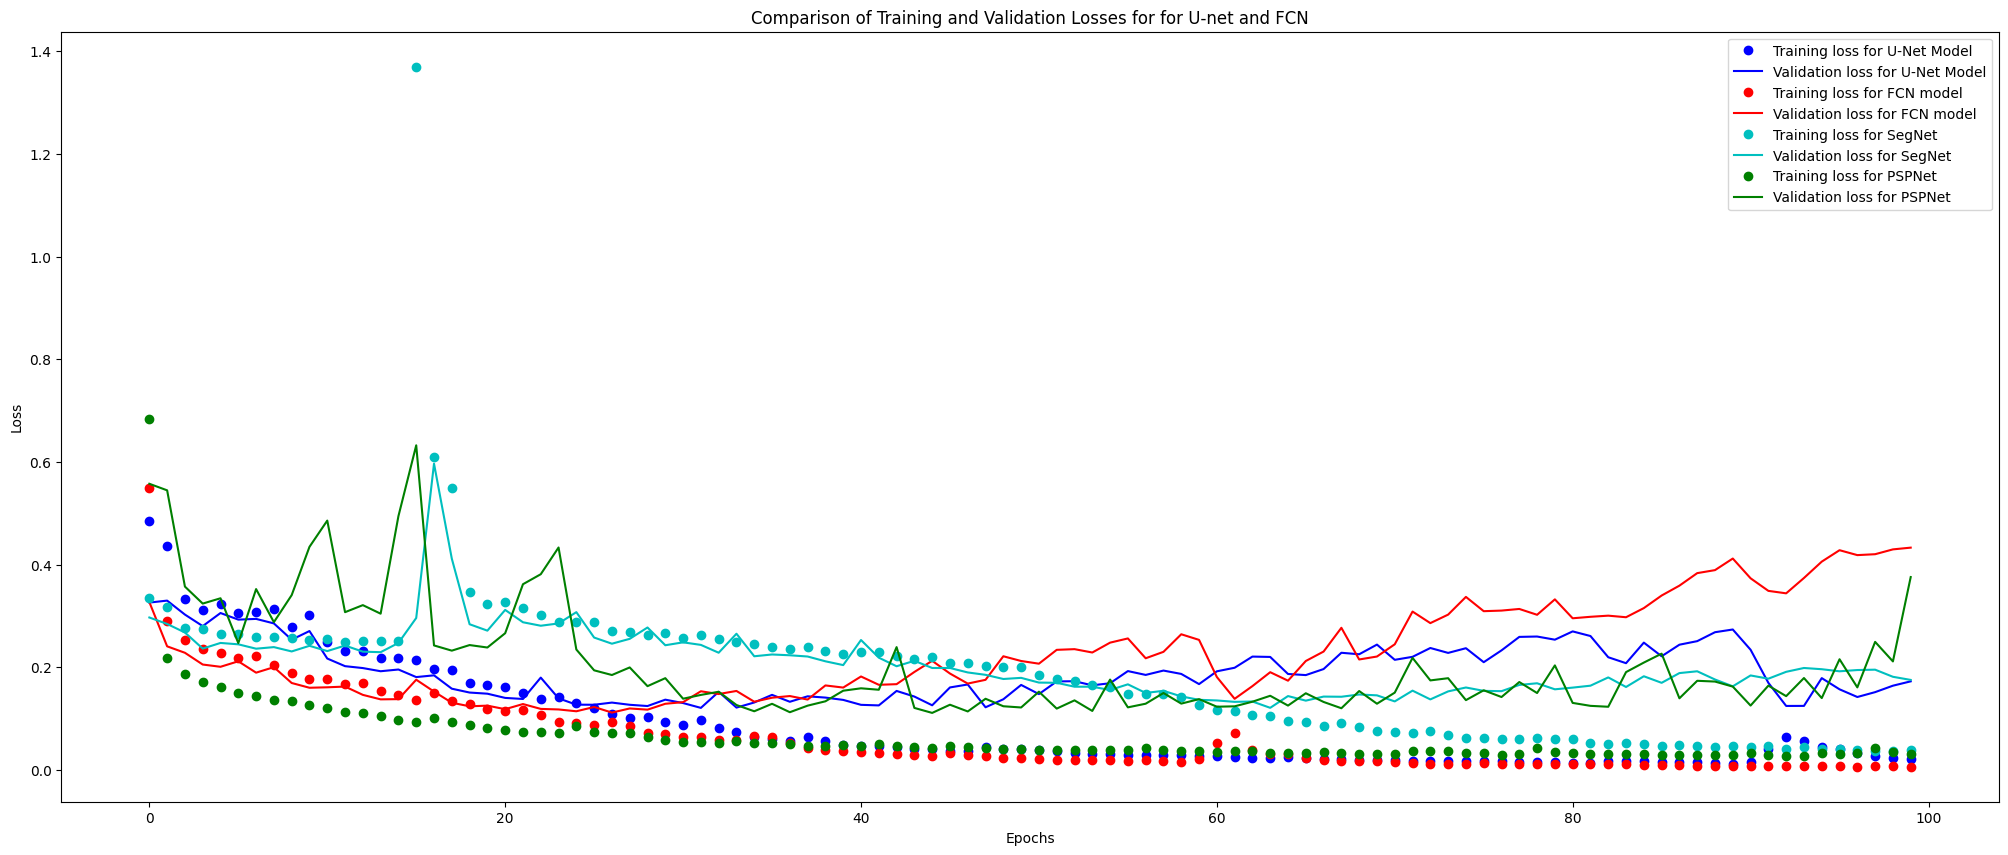

In [ ]:
# Compare the losses of three training processes
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
loss2 = history3.history['loss']
val_loss2 = history3.history['val_loss']
loss3 = history4.history['loss']
val_loss3 = history4.history['val_loss']
loss4 = history6.history['loss']
val_loss4 = history6.history['val_loss']


PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, loss4, val_loss4,  'U-Net Model', 'FCN model', 'SegNet', 'PSPNet')

Chart analize:

### U-Net Model:
- **Training Accuracy (Blue Dots)**: The U-Net model shows consistently high training accuracy, reaching close to 1.0.
- **Validation Accuracy (Blue Line)**: The validation accuracy is also high, though slightly lower than the training accuracy. It remains stable around 0.90 to 0.95, indicating good generalization.

### FCN Model:
- **Training Accuracy (Red Dots)**: The FCN model exhibits very high training accuracy, consistently close to 1.0.
- **Validation Accuracy (Red Line)**: The validation accuracy is relatively high, around 0.90 to 0.95. It closely follows the training accuracy, indicating that the model is generalizing well.

### SegNet Model:
- **Training Accuracy (Cyan Dots)**: The SegNet model has lower training accuracy compared to U-Net and FCN, showing fluctuations and stabilizing around 0.85 to 0.90.
- **Validation Accuracy (Cyan Line)**: The validation accuracy follows a similar trend to the training accuracy, indicating some overfitting but generally good performance.

### PSPNet Model:
- **Training Accuracy (Green Dots)**: The PSPNet model exhibits significant fluctuations in training accuracy, indicating potential instability during training. The accuracy ranges from 0.75 to 0.95.
- **Validation Accuracy (Green Line)**: The validation accuracy is also fluctuating, with noticeable drops, but it generally remains around 0.85 to 0.90. This suggests that while the model has potential, it may require further tuning.

### Summary
1. **U-Net**: Shows high and stable accuracy, both in training and validation, indicating strong performance and generalization. It seems to be the best performer overall.
2. **FCN**: Similar to U-Net, with very high accuracy and good generalization. It is a strong contender and performs nearly as well as U-Net.
3. **SegNet**: Demonstrates good accuracy but with some instability. It can be a viable option but may need additional tuning or regularization to improve stability.
4. **PSPNet**: Exhibits instability with fluctuating accuracies. Further fine-tuning, such as adjusting learning rates, regularization techniques, or data augmentation, might be necessary to stabilize the training process and improve performance.

In [ ]:
history_df = pd.DataFrame(history6.history)
history_df['epoch'] = history6.epoch

# Extract the highest accuracy and the lowest loss value
max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()


print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

# Optionally, display the DataFrame
print(history_df)

Highest Accuracy: 0.9871832728385925
Lowest Loss: 0.027126166969537735
        loss  accuracy  val_loss  val_accuracy  epoch
0   0.683281  0.764063  0.557404      0.724664      0
1   0.218123  0.919052  0.544630      0.661472      1
2   0.187295  0.927750  0.357099      0.833769      2
3   0.170846  0.933100  0.324002      0.842067      3
4   0.160866  0.935666  0.334356      0.835684      4
..       ...       ...       ...           ...    ...
95  0.030840  0.985711  0.215551      0.925658     95
96  0.032744  0.984812  0.160724      0.952695     96
97  0.043248  0.981197  0.249424      0.947661     97
98  0.034891  0.983983  0.211326      0.949837     98
99  0.030695  0.985715  0.375677      0.939439     99

[100 rows x 5 columns]


#**Experiments with U-Net**


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4)):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_regularizer=kernel_regularizer)(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_regularizer=kernel_regularizer)(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(inputs, filters, pool_size=(2, 2), dropout=0.3):
    conv = conv_block(inputs, filters)
    pool = MaxPooling2D(pool_size)(conv)
    pool = Dropout(dropout)(pool)
    return conv, pool

def decoder_block(inputs, skip_features, filters, kernel_size=3, activation='relu', padding='same', dropout=0.3):
    up = UpSampling2D((2, 2))(inputs)
    merge = Concatenate()([up, skip_features])
    conv = conv_block(merge, filters)
    conv = Dropout(dropout)(conv)
    return conv

def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

# Adjust input_shape as necessary
input_shape = (128, 128, 1)
model = build_model(input_shape)

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Summary of the model
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['batch_normalization[0][0

In [ ]:
# Train the model without the EarlyStopping callback
history7 = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
19/19 [==============================] - 69s 1s/step - loss: 1.3078 - accuracy: 0.6662 - val_loss: 13.9247 - val_accuracy: 0.8760
Epoch 2/100
19/19 [==============================] - 10s 532ms/step - loss: 1.1471 - accuracy: 0.8523 - val_loss: 1170.7847 - val_accuracy: 0.0932
Epoch 3/100
19/19 [==============================] - 10s 537ms/step - loss: 0.9792 - accuracy: 0.9141 - val_loss: 208.3927 - val_accuracy: 0.1184
Epoch 4/100
19/19 [==============================] - 10s 542ms/step - loss: 0.8528 - accuracy: 0.9218 - val_loss: 608.9085 - val_accuracy: 0.0935
Epoch 5/100
19/19 [==============================] - 10s 548ms/step - loss: 0.7509 - accuracy: 0.9259 - val_loss: 5.8789 - val_accuracy: 0.5508
Epoch 6/100
19/19 [==============================] - 11s 558ms/step - loss: 0.6724 - accuracy: 0.9297 - val_loss: 190.5362 - val_accuracy: 0.1369
Epoch 7/100
19/19 [==============================] - 11s 561ms/step - loss: 0.6301 - accuracy: 0.9253 - val_loss: 24.1280 - val_a

In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.746544
Precision Score = 0.555
Recall Score = 0.942
F1 Score = 0.699


In [ ]:
import pandas as pd
# Extract accuracy and loss values from the history object
accuracy = history7.history['accuracy']
val_accuracy = history7.history['val_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

# Create a DataFrame to store the values
history_df = pd.DataFrame({
    'epoch': history7.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history7.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history7.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history7.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history7.epoch)  # Adding F1 score to all rows
})

# Define the path to save the CSV file (adjust the path as needed)
csv_file_path = '/content/drive/MyDrive/training_log_7.csv'

# Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_7.csv


In [ ]:
history_df = pd.DataFrame(history7.history)
history_df['epoch'] = history7.epoch

# Extract the highest accuracy and the lowest loss value
max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()


print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

# Optionally, display the DataFrame
print(history_df)

Highest Accuracy: 0.9697026610374451
Lowest Loss: 0.15057647228240967
        loss  accuracy     val_loss  val_accuracy  epoch
0   1.307850  0.666155    13.924688      0.876047      0
1   1.147105  0.852253  1170.784668      0.093181      1
2   0.979198  0.914128   208.392670      0.118382      2
3   0.852824  0.921808   608.908508      0.093451      3
4   0.750923  0.925850     5.878895      0.550823      4
..       ...       ...          ...           ...    ...
95  0.150576  0.969703     0.358474      0.907115     95
96  0.159078  0.964294     0.201914      0.951897     96
97  0.156336  0.967134     0.229793      0.945599     97
98  0.178800  0.961709     0.273804      0.934841     98
99  0.187473  0.961924     0.212495      0.954318     99

[100 rows x 5 columns]


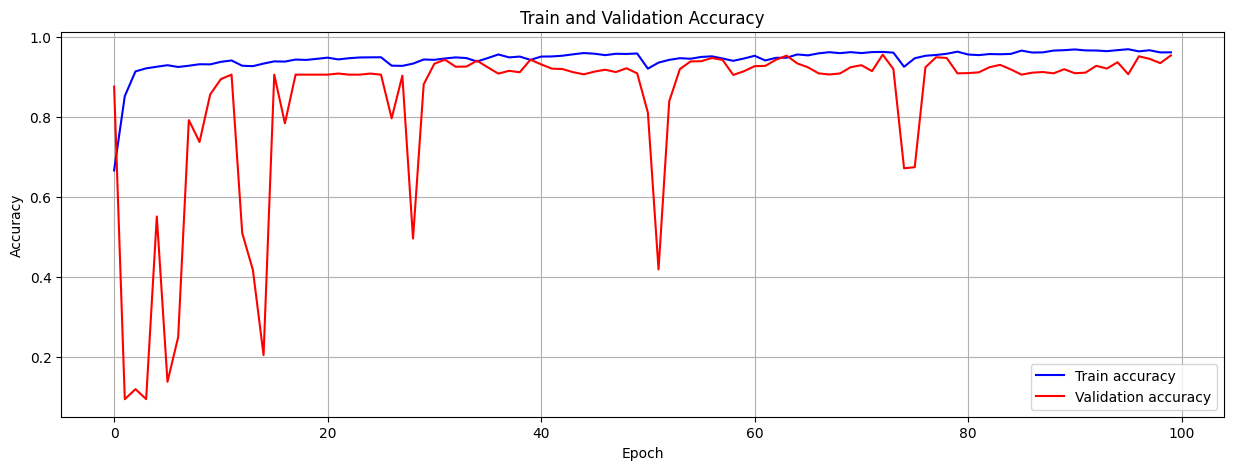

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history7.epoch, history7.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history7.epoch, history7.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Chart analize:

1. **High Training Accuracy:**
   - The model achieves and maintains a high training accuracy, indicating effective learning from the training data.

2. **Validation Accuracy Fluctuations:**
   - The validation accuracy shows significant initial fluctuations and occasional sharp dips throughout the training. These fluctuations could indicate overfitting or sensitivity to specific validation batches.

3. **Rapid Learning:**
   - The model quickly reaches high accuracy on both the training and validation sets, suggesting effective initial learning but potential issues with stability and generalization.


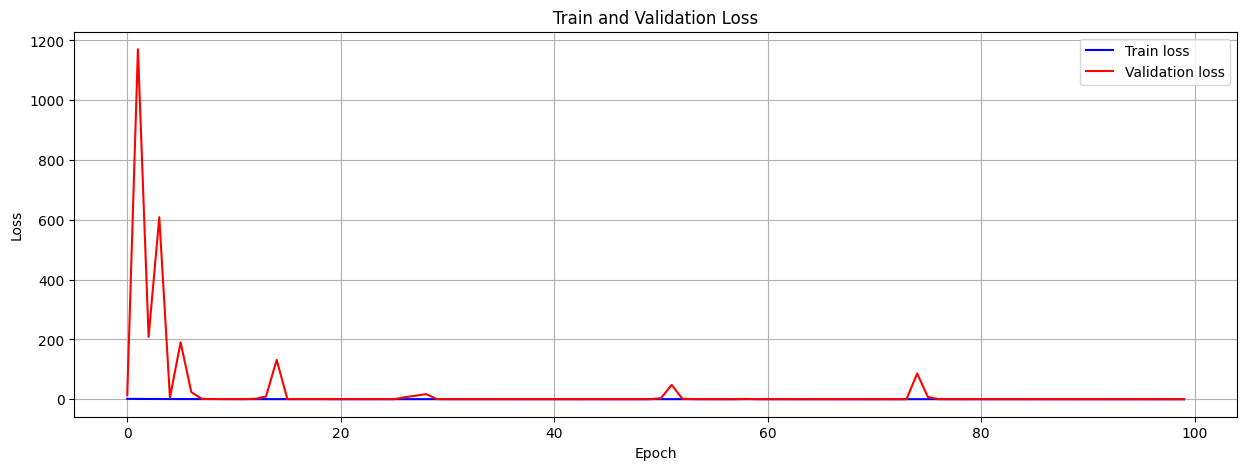

In [ ]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history7.epoch, history7.history['loss'], label="Train loss", color='blue')
plt.plot(history7.epoch, history7.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Chart analize:

1. **Initial Spikes in Validation Loss:**
   - The validation loss exhibits significant spikes early in the training phase, suggesting the model might have encountered difficult examples or instability in the early training stages.

2. **Rapid Stabilization:**
   - After the initial spikes, both training and validation losses drop to near-zero values and remain constant, indicating that the model quickly learns and minimizes error effectively after the early epochs.

3. **Occasional Validation Spikes:**
   - The periodic spikes in validation loss throughout the training process indicate that the model occasionally struggles with specific batches or data points in the validation set, but overall maintains low loss values.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4)):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_regularizer=kernel_regularizer)(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_regularizer=kernel_regularizer)(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(inputs, filters, pool_size=(2, 2), dropout=0.5):  # Increased dropout rate
    conv = conv_block(inputs, filters)
    pool = MaxPooling2D(pool_size)(conv)
    pool = Dropout(dropout)(pool)
    return conv, pool

def decoder_block(inputs, skip_features, filters, kernel_size=3, activation='relu', padding='same', dropout=0.5):  # Increased dropout rate
    up = UpSampling2D((2, 2))(inputs)
    merge = Concatenate()([up, skip_features])
    conv = conv_block(merge, filters)
    conv = Dropout(dropout)(conv)
    return conv

def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

# Adjust input_shape as necessary
input_shape = (128, 128, 1)
model = build_model(input_shape)

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Summary of the model
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 128, 128, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 64)         36928     ['batch_normalization_18[0

In [ ]:
# Train the model without the EarlyStopping callback
history8 = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
19/19 [==============================] - 66s 1s/step - loss: 1.3892 - accuracy: 0.6095 - val_loss: 232.0614 - val_accuracy: 0.1143
Epoch 2/100
19/19 [==============================] - 10s 551ms/step - loss: 1.1970 - accuracy: 0.7450 - val_loss: 4558.9897 - val_accuracy: 0.0853
Epoch 3/100
19/19 [==============================] - 10s 541ms/step - loss: 1.0178 - accuracy: 0.8538 - val_loss: 269.7279 - val_accuracy: 0.1578
Epoch 4/100
19/19 [==============================] - 10s 540ms/step - loss: 0.9047 - accuracy: 0.8876 - val_loss: 2.9502 - val_accuracy: 0.6910
Epoch 5/100
19/19 [==============================] - 10s 537ms/step - loss: 0.8489 - accuracy: 0.8947 - val_loss: 168.4460 - val_accuracy: 0.1245
Epoch 6/100
19/19 [==============================] - 10s 539ms/step - loss: 0.7304 - accuracy: 0.9186 - val_loss: 49.5405 - val_accuracy: 0.3738
Epoch 7/100
19/19 [==============================] - 10s 542ms/step - loss: 0.6528 - accuracy: 0.9261 - val_loss: 17.0481 - val_a

In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.68872696
Precision Score = 0.437
Recall Score = 0.945
F1 Score = 0.597


In [ ]:
import pandas as pd
# Extract accuracy and loss values from the history object
accuracy = history8.history['accuracy']
val_accuracy = history8.history['val_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']

# Create a DataFrame to store the values
history_df = pd.DataFrame({
    'epoch': history8.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history8.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history8.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history8.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history8.epoch)  # Adding F1 score to all rows
})

# Define the path to save the CSV file (adjust the path as needed)
csv_file_path = '/content/drive/MyDrive/training_log_8.csv'

# Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_8.csv


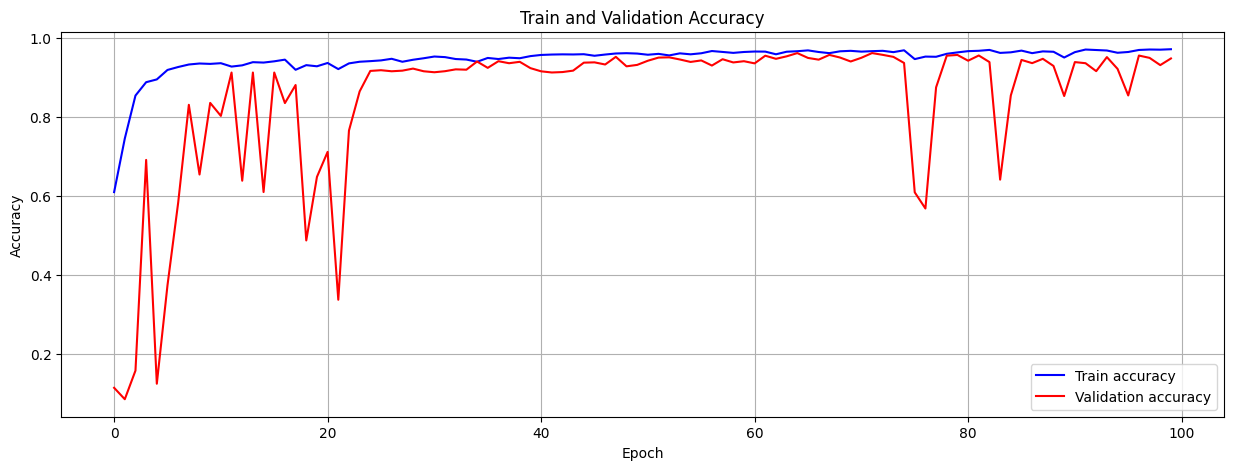

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history8.epoch, history8.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history8.epoch, history8.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Chart analize:

1. **High Training Accuracy:**
   - The model achieves and maintains a high training accuracy, indicating effective learning from the training data.

2. **Validation Accuracy Fluctuations:**
   - The validation accuracy shows significant initial fluctuations and occasional sharp dips throughout the training. These fluctuations could indicate overfitting or sensitivity to specific validation batches.

3. **Rapid Learning:**
   - The model quickly reaches high accuracy on both the training and validation sets, suggesting effective initial learning but potential issues with stability and generalization.

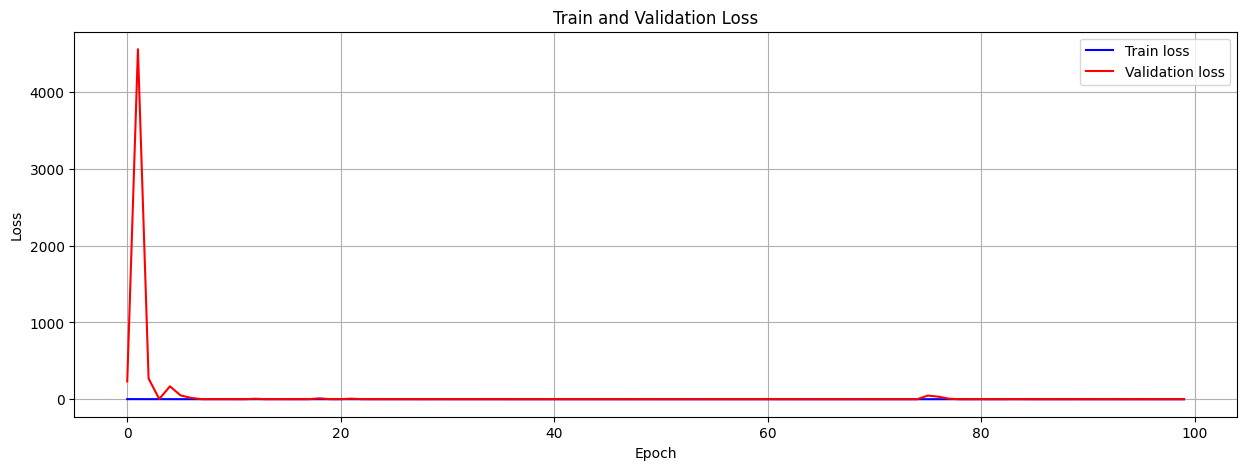

In [ ]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history8.epoch, history8.history['loss'], label="Train loss", color='blue')
plt.plot(history8.epoch, history8.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Chart analize:

1. **Initial Spike in Validation Loss:**
   - The validation loss exhibits a significant spike early in the training phase, suggesting the model might have encountered difficult examples or there could have been instability in the early training stages.

2. **Rapid Stabilization:**
   - After the initial spike, both training and validation losses drop to near-zero values and remain constant, indicating that the model quickly learns and minimizes error effectively after the early epochs.

3. **Potential Overfitting:**
   - The consistent near-zero loss values for both training and validation losses suggest that the model might be overfitting. However, the stable validation loss indicates that this overfitting might not be severe, but the model might not be encountering challenging examples in the validation set after the early epochs.


## U-Netwith attention

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation, UpSampling2D

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), padding='same')(x)
    theta_x = BatchNormalization()(theta_x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)
    phi_g = BatchNormalization()(phi_g)

    add_xg = layers.add([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)

    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    psi = BatchNormalization()(psi)
    sigmoid_xg = Activation('sigmoid')(psi)

    upsample_psi = UpSampling2D(size=(x.shape[1] // sigmoid_xg.shape[1], x.shape[2] // sigmoid_xg.shape[2]))(sigmoid_xg)
    upsample_psi = layers.multiply([upsample_psi, x])

    result = Conv2D(x.shape[-1], (1, 1), padding='same')(upsample_psi)
    result_bn = BatchNormalization()(result)
    return result_bn

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(x, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(x)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d1 = attention_block(d1, s4, 512)

    d2 = decoder_block(d1, s3, 256)
    d2 = attention_block(d2, s3, 256)

    d3 = decoder_block(d2, s2, 128)
    d3 = attention_block(d3, s2, 128)

    d4 = decoder_block(d3, s1, 64)
    d4 = attention_block(d4, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="Attention_U-Net")
    return model

size = 128
model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()


Model: "Attention_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_126 (Conv2D)         (None, 128, 128, 64)         640       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_92 (Ba  (None, 128, 128, 64)         256       ['conv2d_126[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_100 (Activation  (None, 128, 128, 64)         0         ['batch_normaliz

In [ ]:
# Train the model without the EarlyStopping callback
history9 = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
19/19 [==============================] - 76s 1s/step - loss: 0.6785 - accuracy: 0.6438 - val_loss: 0.8156 - val_accuracy: 0.5804
Epoch 2/100
19/19 [==============================] - 10s 526ms/step - loss: 0.5496 - accuracy: 0.9060 - val_loss: 1007.9662 - val_accuracy: 0.0818
Epoch 3/100
19/19 [==============================] - 10s 526ms/step - loss: 0.4395 - accuracy: 0.9103 - val_loss: 293.7470 - val_accuracy: 0.2706
Epoch 4/100
19/19 [==============================] - 10s 543ms/step - loss: 0.3421 - accuracy: 0.9169 - val_loss: 7.8703 - val_accuracy: 0.4663
Epoch 5/100
19/19 [==============================] - 10s 527ms/step - loss: 0.2915 - accuracy: 0.9209 - val_loss: 38.3512 - val_accuracy: 0.2975
Epoch 6/100
19/19 [==============================] - 10s 529ms/step - loss: 0.3655 - accuracy: 0.9116 - val_loss: 6667.3066 - val_accuracy: 0.1126
Epoch 7/100
19/19 [==============================] - 10s 530ms/step - loss: 0.2592 - accuracy: 0.9231 - val_loss: 8.2769 - val_acc

In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.76498306
Precision Score = 0.656
Recall Score = 0.815
F1 Score = 0.727


In [ ]:
import pandas as pd
# Extract accuracy and loss values from the history object
accuracy = history9.history['accuracy']
val_accuracy = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

# Create a DataFrame to store the values
history_df = pd.DataFrame({
    'epoch': history9.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history9.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history9.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history9.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history9.epoch)  # Adding F1 score to all rows
})

# Define the path to save the CSV file (adjust the path as needed)
csv_file_path = '/content/drive/MyDrive/training_log_9.csv'

# Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_9.csv


In [ ]:
history_df = pd.DataFrame(history9.history)
history_df['epoch'] = history9.epoch

# Extract the highest accuracy and the lowest loss value
max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()


print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

# Optionally, display the DataFrame
print(history_df)

Highest Accuracy: 0.9803303480148315
Lowest Loss: 0.04448104277253151
        loss  accuracy     val_loss  val_accuracy  epoch
0   0.678504  0.643835     0.815594      0.580421      0
1   0.549604  0.906032  1007.966187      0.081801      1
2   0.439472  0.910299   293.746979      0.270631      2
3   0.342149  0.916851     7.870316      0.466294      3
4   0.291525  0.920878    38.351181      0.297516      4
..       ...       ...          ...           ...    ...
95  0.053060  0.977664     0.125865      0.963395     95
96  0.050061  0.978104     0.145668      0.958742     96
97  0.046694  0.979610     0.126704      0.962140     97
98  0.044481  0.980330     0.159601      0.948833     98
99  0.049432  0.978722     0.158272      0.957781     99

[100 rows x 5 columns]


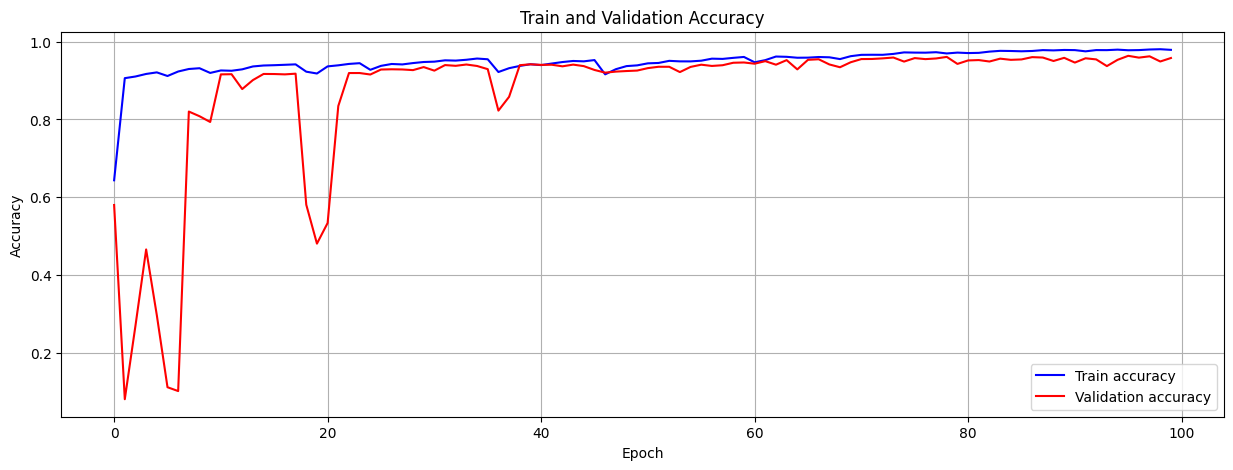

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history9.epoch, history9.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history9.epoch, history9.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Chart analize:

1. **Rapid Learning and Stabilization:**
   - The model quickly learns and achieves high training accuracy. The validation accuracy also improves rapidly but shows initial instability before stabilizing.

2. **High Training Accuracy:**
   - The high and stable training accuracy indicates the model has effectively learned the training data. However, the slight gap between training and validation accuracy suggests some degree of overfitting.

3. **Validation Fluctuations:**
   - The initial fluctuations in validation accuracy might be due to several factors, such as data preprocessing, variability in the validation set, or the learning rate being too high initially.


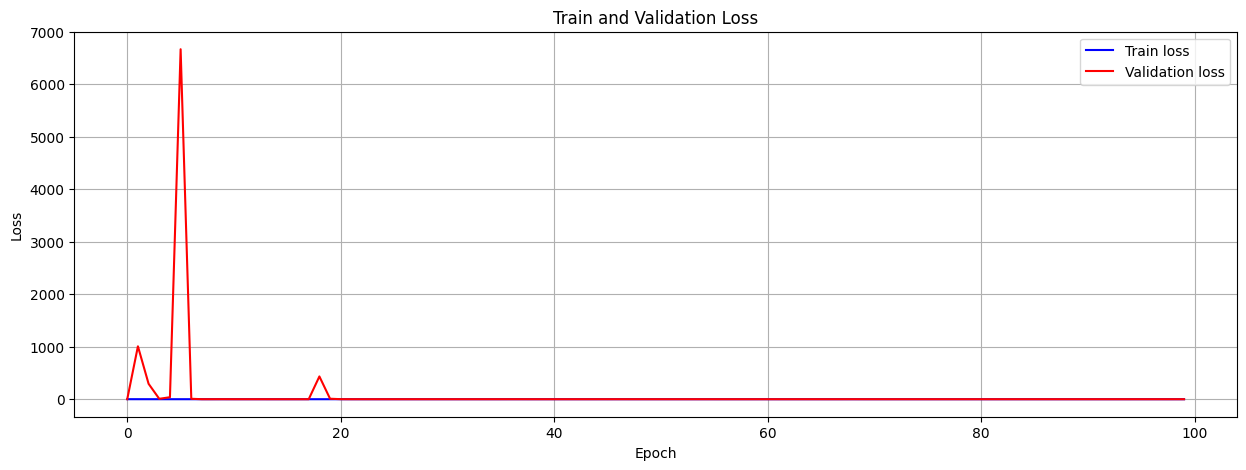

In [ ]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history9.epoch, history9.history['loss'], label="Train loss", color='blue')
plt.plot(history9.epoch, history9.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Chart analize:

1. **Initial Spikes in Validation Loss:**
   - The validation loss exhibits two significant spikes, one around epoch 5 and another around epoch 20. These spikes suggest that the model might have encountered difficult examples or there could have been instability in the early training stages.

2. **Rapid Stabilization:**
   - After the initial spikes, both training and validation losses drop to near-zero values and remain constant, indicating that the model quickly learns and minimizes error effectively after the early epochs.

3. **Potential Overfitting:**
   - The consistent near-zero loss values for both training and validation losses suggest that the model might be overfitting. However, the stable validation loss indicates that this overfitting might not be severe, but the model might not be encountering challenging examples in the validation set after the early epochs.

Fluctuations in some epochs may indicate problems with data preprocessing.
The validation set immediately has low validation values, which may lead to errors in the analysis. collections may not be well represented


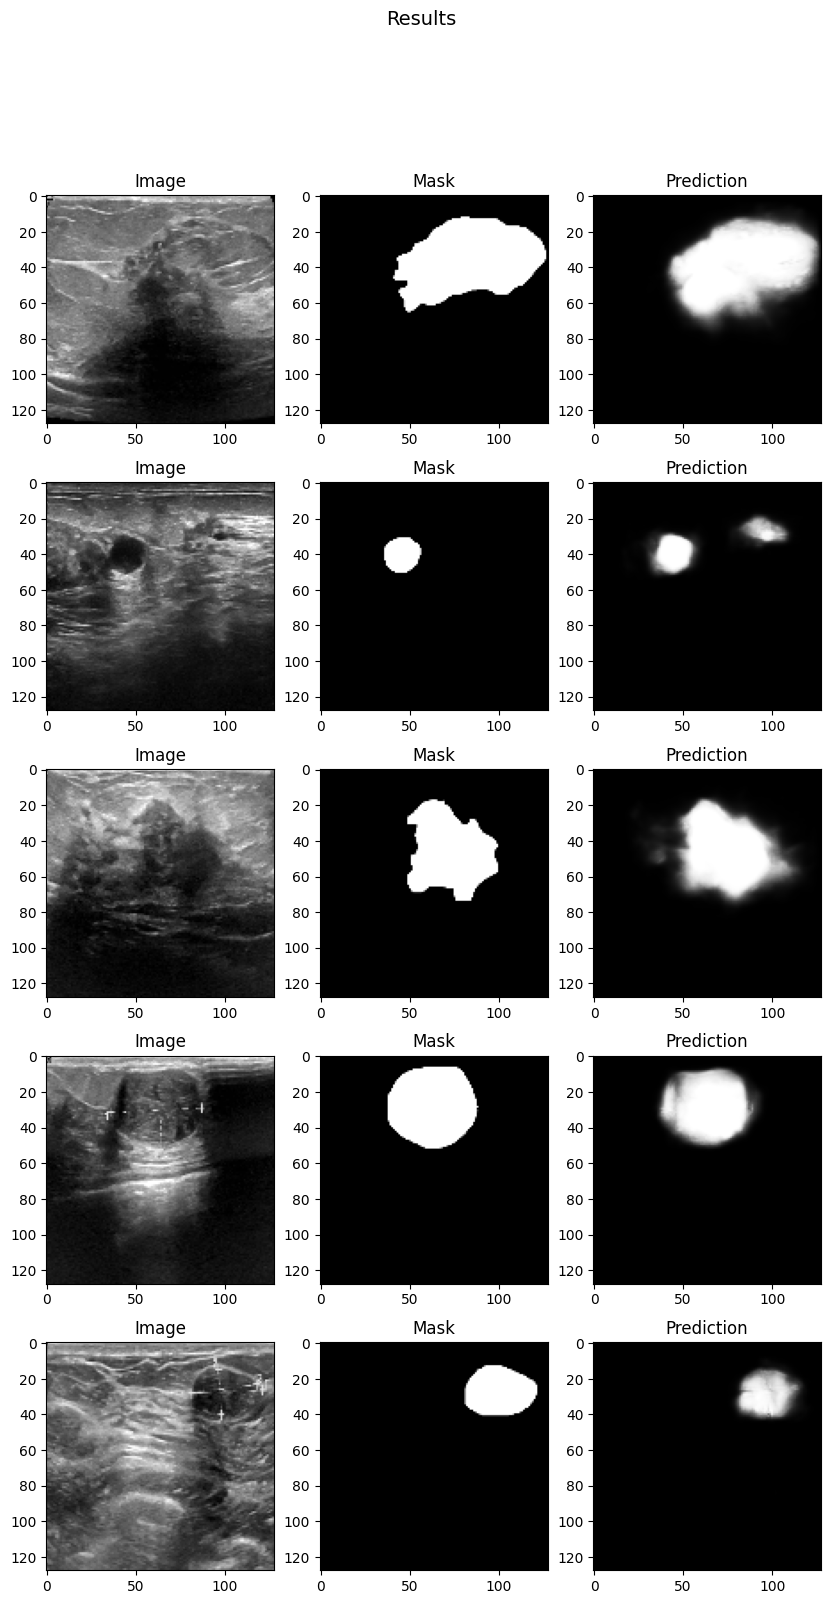

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=14)
plt.show()

Table analize:

1. **Blurriness in Predictions:**
   - Across all examples, the model predictions are consistently blurred compared to the true masks. This indicates the model's difficulty in precisely defining the lesion boundaries.

2. **General Accuracy:**
   - The model generally identifies the correct regions of interest but often extends beyond the true boundaries, leading to over-prediction in some areas.

3. **Model Uncertainty:**
   - The blurred edges in the predictions suggest that the model is uncertain about the exact boundaries of the lesions, which could be addressed by further refining the model or using more precise loss functions during training.

1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 344ms/step


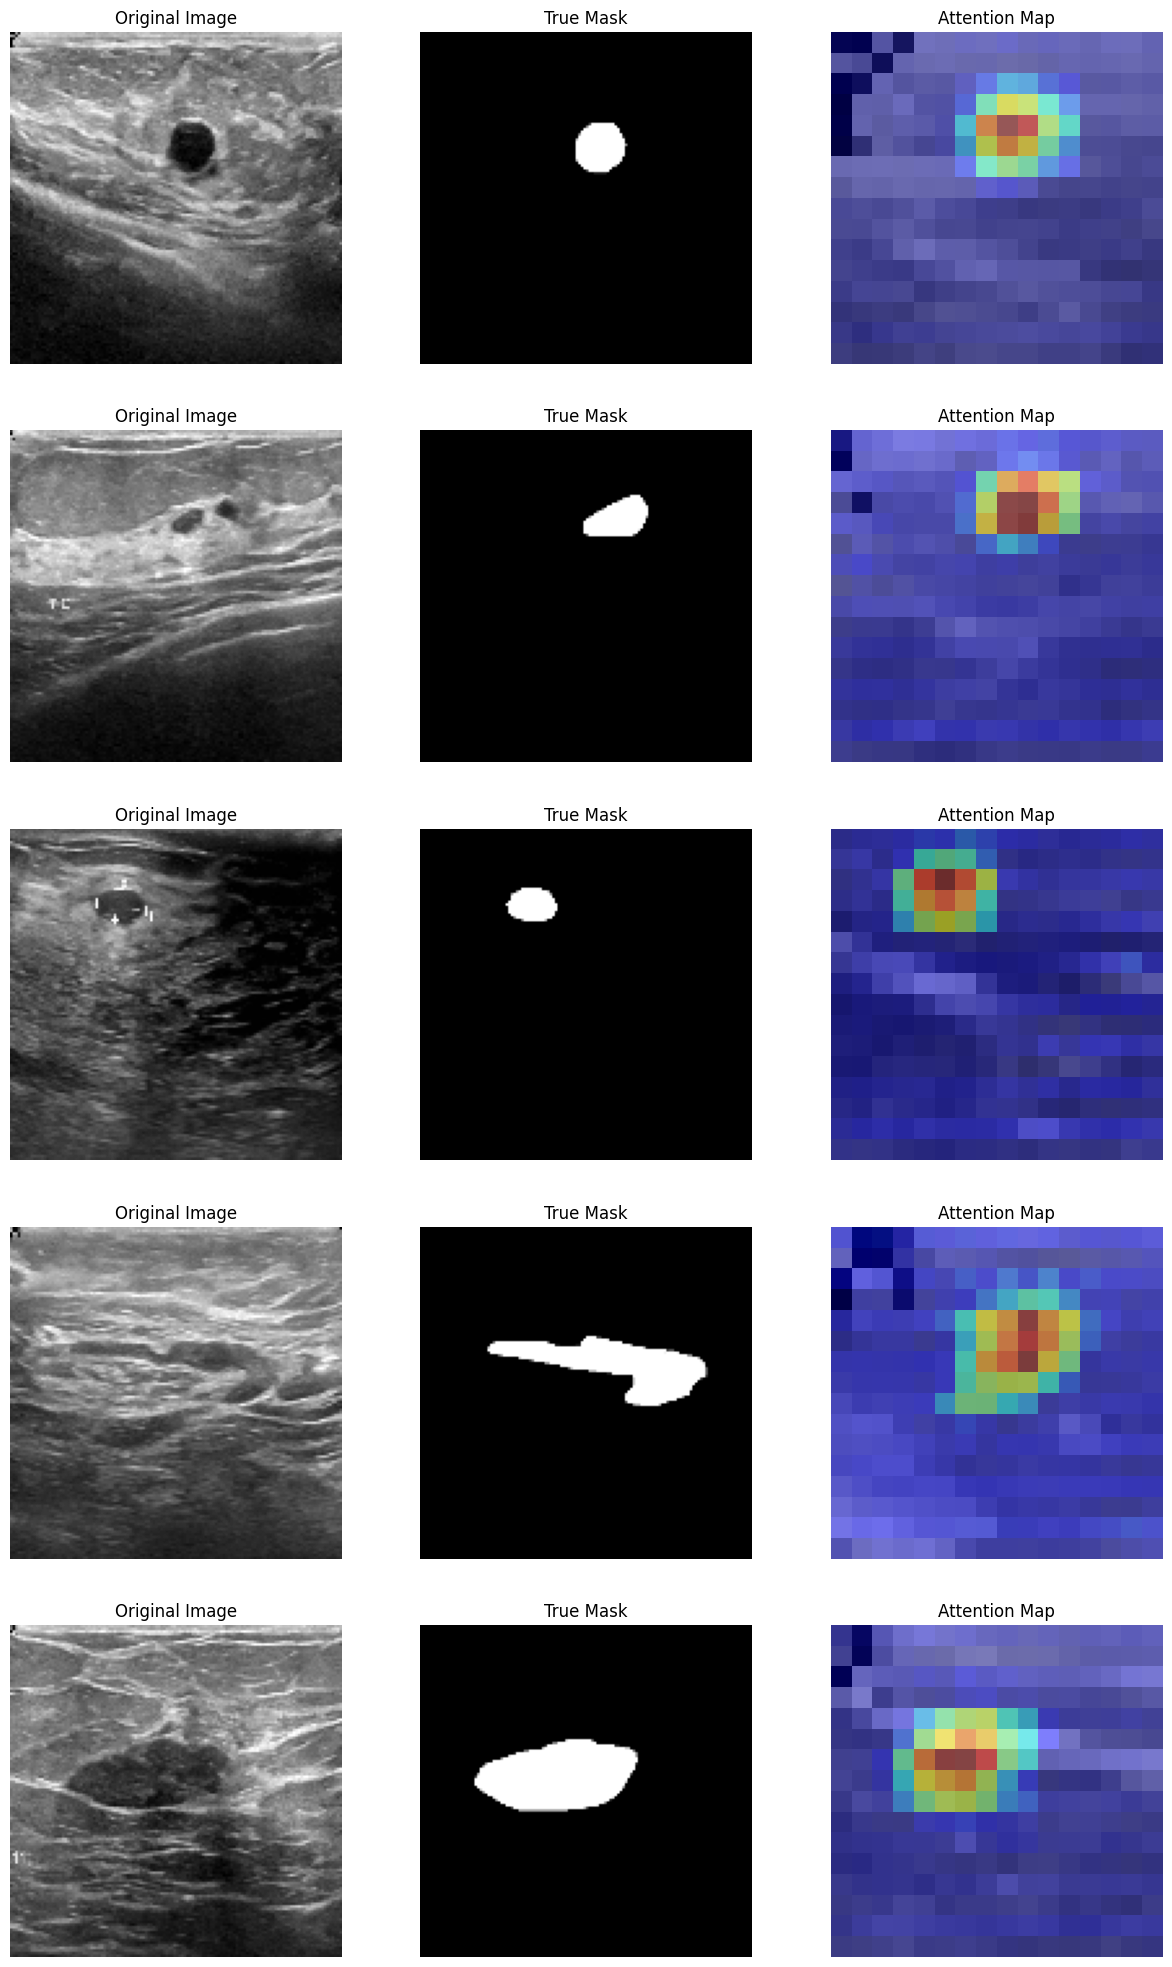

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def get_attention_map(model, input_image):
    attention_layer_name = "conv2d_138"
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                              outputs=model.get_layer(attention_layer_name).output)
    attention_map = intermediate_layer_model.predict(input_image)
    attention_map = np.mean(attention_map, axis=-1)
    return attention_map

num_examples = 5
example_images = X_test[:num_examples]
example_masks = y_test[:num_examples]
predicted_masks = model.predict(example_images)
fig, axs = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))

for i in range(num_examples):
    original_image = example_images[i].squeeze()
    true_mask = example_masks[i].squeeze()
    predicted_mask = predicted_masks[i].squeeze()
    attention_map = get_attention_map(model, np.expand_dims(example_images[i], axis=0)).squeeze()

    axs[i, 0].imshow(original_image, cmap='gray')
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_mask, cmap='gray')
    axs[i, 1].set_title('True Mask')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(original_image, cmap='gray')
    axs[i, 2].imshow(attention_map, cmap='jet', alpha=0.5)
    axs[i, 2].set_title('Attention Map')
    axs[i, 2].axis('off')

plt.show()


Table analize:

1. **Model Focus:**
   - The attention maps consistently show strong focus on the lesion areas across different images, indicating that the model correctly identifies the regions of interest for segmentation.

2. **Consistency:**
   - The attention maps align well with the true masks, suggesting that the model's predictions are based on relevant parts of the images.

3. **Robustness:**
   - The model performs well across different types of lesions (small, large, and irregular shapes), as indicated by the attention maps focusing on the correct regions in each case.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def attention_block(x, g, num_filters):
    theta_x = layers.Conv2D(num_filters, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = layers.Conv2D(num_filters, (1, 1), padding='same')(g)
    concat_xg = layers.add([theta_x, phi_g])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    psi = layers.Activation('sigmoid')(psi)

    upsample_size = (x.shape[1] // g.shape[1], x.shape[2] // g.shape[2])

    upsample_psi = layers.UpSampling2D(size=upsample_size)(psi)
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(x.shape[-1], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def res_conv_block(x, filter_size, num_filters, dropout_rate=0.0, batch_norm=True):
    conv1 = layers.Conv2D(num_filters, (filter_size, filter_size), padding='same')(x)
    if batch_norm:
        conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv2 = layers.Conv2D(num_filters, (filter_size, filter_size), padding='same')(conv1)
    if batch_norm:
        conv2 = layers.BatchNormalization()(conv2)
    if dropout_rate > 0:
        conv2 = layers.Dropout(dropout_rate)(conv2)
    shortcut = layers.Conv2D(num_filters, (1, 1), padding='same')(x)
    if batch_norm:
        shortcut = layers.BatchNormalization()(shortcut)
    res_path = layers.add([shortcut, conv2])
    res_path = layers.Activation('relu')(res_path)
    return res_path

def conv_block(x, filter_size, num_filters, dropout_rate=0.0, batch_norm=True):
    conv = layers.Conv2D(num_filters, (filter_size, filter_size), padding='same')(x)
    if batch_norm:
        conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(num_filters, (filter_size, filter_size), padding='same')(conv)
    if batch_norm:
        conv = layers.BatchNormalization()(conv)
    if dropout_rate > 0:
        conv = layers.Dropout(dropout_rate)(conv)
    return conv

def gating_signal(input, num_filters, batch_norm=True):
    conv = layers.Conv2D(num_filters, (1, 1), padding='same')(input)
    if batch_norm:
        conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    return conv

In [ ]:

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    FILTER_NUM = 64    # number of basic filters for the first layer
    FILTER_SIZE = 3    # size of the convolutional filter
    UP_SAMP_SIZE = 2   # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128)

    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64)

    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32)

    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16)

    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    gating_32 = gating_signal(up_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    gating_64 = gating_signal(up_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    gating_128 = gating_signal(up_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1))(up_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

model = Attention_ResUNet(input_shape=(128, 128, 1), NUM_CLASSES=1, dropout_rate=0.5, batch_norm=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_232 (Conv2D)         (None, 128, 128, 64)         640       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_179 (B  (None, 128, 128, 64)         256       ['conv2d_232[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_168 (Activation  (None, 128, 128, 64)         0         ['batch_normali

In [ ]:
history10 = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
19/19 [==============================] - 72s 1s/step - loss: 0.6590 - accuracy: 0.8107 - val_loss: 73094.7500 - val_accuracy: 0.0817
Epoch 2/100
19/19 [==============================] - 14s 713ms/step - loss: 0.5929 - accuracy: 0.8822 - val_loss: 3114.9045 - val_accuracy: 0.0817
Epoch 3/100
19/19 [==============================] - 13s 700ms/step - loss: 0.5782 - accuracy: 0.8959 - val_loss: 902.8145 - val_accuracy: 0.0817
Epoch 4/100
19/19 [==============================] - 14s 719ms/step - loss: 0.5686 - accuracy: 0.8923 - val_loss: 58.0426 - val_accuracy: 0.0854
Epoch 5/100
19/19 [==============================] - 14s 725ms/step - loss: 0.5503 - accuracy: 0.9023 - val_loss: 31.1242 - val_accuracy: 0.0888
Epoch 6/100
19/19 [==============================] - 14s 718ms/step - loss: 0.5390 - accuracy: 0.9149 - val_loss: 5.7406 - val_accuracy: 0.1640
Epoch 7/100
19/19 [==============================] - 13s 701ms/step - loss: 0.5311 - accuracy: 0.9140 - val_loss: 0.9977 - val_a

In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.5102537
Precision Score = 0.100
Recall Score = 0.746
F1 Score = 0.177


In [ ]:
history_df = pd.DataFrame(history10.history)
history_df['epoch'] = history10.epoch

# Extract the highest accuracy and the lowest loss value
max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()


print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

# Optionally, display the DataFrame
print(history_df)

Highest Accuracy: 0.9839306473731995
Lowest Loss: 0.13123969733715057
        loss  accuracy      val_loss  val_accuracy  epoch
0   0.658986  0.810711  73094.750000      0.081741      0
1   0.592933  0.882179   3114.904541      0.081741      1
2   0.578218  0.895913    902.814453      0.081741      2
3   0.568649  0.892326     58.042591      0.085397      3
4   0.550267  0.902276     31.124151      0.088757      4
..       ...       ...           ...           ...    ...
95  0.136291  0.983618      0.266780      0.922395     95
96  0.136638  0.982873      0.271994      0.922489     96
97  0.134130  0.983242      0.276117      0.920637     97
98  0.132190  0.983743      0.260871      0.924594     98
99  0.131240  0.983523      0.267728      0.921248     99

[100 rows x 5 columns]


In [ ]:
import pandas as pd
# Extract accuracy and loss values from the history object
accuracy = history10.history['accuracy']
val_accuracy = history10.history['val_accuracy']
loss = history10.history['loss']
val_loss = history10.history['val_loss']

# Create a DataFrame to store the values
history_df = pd.DataFrame({
    'epoch': history10.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history10.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history10.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history10.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history10.epoch)  # Adding F1 score to all rows
})

# Define the path to save the CSV file (adjust the path as needed)
csv_file_path = '/content/drive/MyDrive/training_log_10.csv'

# Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_10.csv


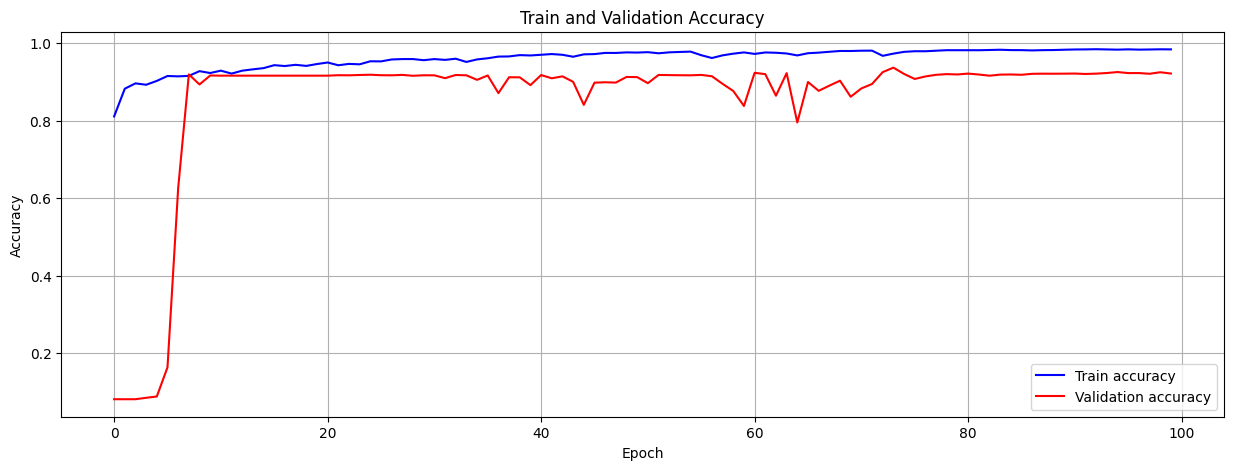

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history10.epoch, history10.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history10.epoch, history10.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Chart analize:

1. **High Training Accuracy:**
   - The model achieves nearly perfect training accuracy, indicating that it has successfully learned the patterns in the training data.

2. **Stable Validation Accuracy:**
   - Despite the high training accuracy, the validation accuracy stabilizes around 92%, which is a good sign of generalization. However, the gap between training and validation accuracy suggests some overfitting.

3. **Fluctuations in Validation Accuracy:**
   - The minor fluctuations in validation accuracy, especially in the mid and late training phases, indicate that while the model generalizes well, there might be occasional overfitting to certain features of the training data.


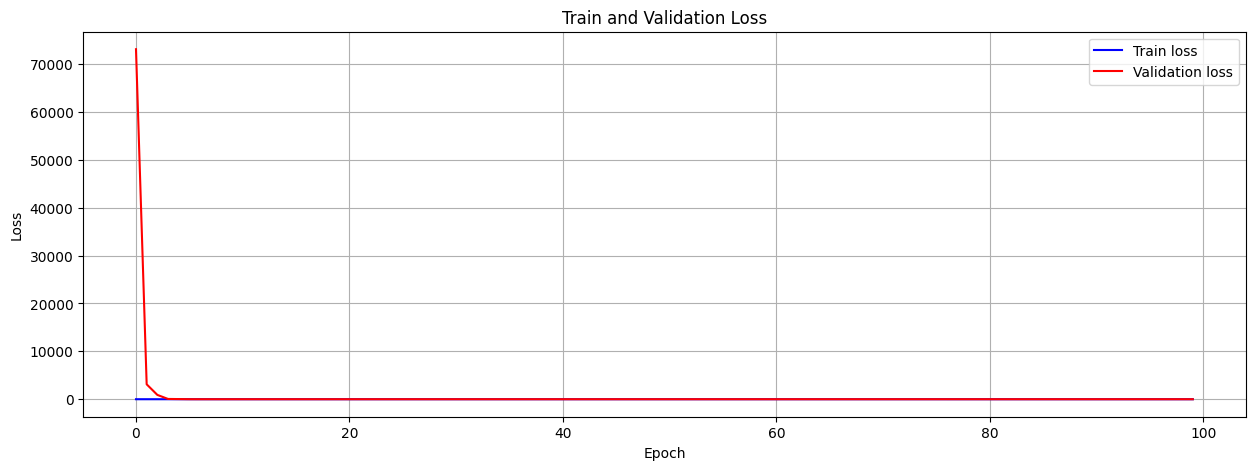

In [ ]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history10.epoch, history10.history['loss'], label="Train loss", color='blue')
plt.plot(history10.epoch, history10.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Chart analize:

1. **Sharp Drop in Validation Loss:**
   - The validation loss drops drastically from a very high value to near zero within the first few epochs. This suggests that the model quickly learns to fit the data well. However, the initial extremely high validation loss is unusual and may indicate a potential issue with the initial conditions or data scaling.

2. **Low and Constant Loss:**
   - After the initial drop, both training and validation losses remain consistently low and close to zero. This indicates that the model has fit the data very well and there is minimal error in its predictions.

3. **Possible Overfitting:**
   - While low losses are generally desirable, the extremely low and constant values for both training and validation losses could indicate overfitting, where the model has learned to perfectly fit the training data but may not generalize well to unseen data. However, the validation accuracy remains high, which somewhat mitigates this concern.

loss function probably is not appropriate for the task. The extremely low loss values might indicate that the loss function is not providing a meaningful gradient for further learning.


##Experiments with FCN
unsuccessful attempts, clear problems visible in the charts, indicate incorrectly selected hypermarameters

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import numpy as np


def create_fcn_model(input_shape, l2_lambda=0.001, dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(inputs)
    conv1 = Dropout(dropout_rate)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool1)
    conv2 = Dropout(dropout_rate)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Decoder
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool2)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv3)

    up1 = UpSampling2D((2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge1)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv4)

    up2 = UpSampling2D((2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge2)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Cross-validation and data augmentation
# def cross_validate_and_train(X, y, n_splits=5, l2_lambda=0.001, dropout_rate=0.5, batch_size=16, epochs=100):
#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     fold_no = 1
#     val_accuracies = []

#     for train_index, val_index in kfold.split(X, y):
#         print(f'Training fold {fold_no}...')

#         X_train, X_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]

#         # Data augmentation
#         datagen = ImageDataGenerator(
#             rotation_range=10,
#             width_shift_range=0.1,
#             height_shift_range=0.1,
#             shear_range=0.1,
#             zoom_range=0.1,
#             horizontal_flip=True,
#             fill_mode='nearest'
#         )

#         model = create_fcn_model(X_train.shape[1:], l2_lambda=l2_lambda, dropout_rate=dropout_rate)

#         # Early stopping
#         early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#         history12=  model.fit(
#             datagen.flow(X_train, y_train, batch_size=batch_size),
#             validation_data=(X_val, y_val),
#             epochs=epochs,
#             callbacks=[early_stopping],
#             verbose=1
#         )

#         val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
#         val_accuracies.append(val_accuracy)

#         print(f'Fold {fold_no} validation accuracy: {val_accuracy}')
#         fold_no += 1

#     print(f'Mean validation accuracy: {np.mean(val_accuracies)}')



In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Function to create the FCN model
def create_fcn_model(input_shape, l2_lambda=0.001, dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(inputs)
    conv1 = Dropout(dropout_rate)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool1)
    conv2 = Dropout(dropout_rate)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Decoder
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool2)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv3)

    up1 = UpSampling2D((2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge1)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv4)

    up2 = UpSampling2D((2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge2)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Example usage for training the model
# Assuming X_train, y_train, X_val, y_val are your training and validation datasets

# Define input shape
input_shape = (128, 128, 1)  # Example input shape, replace with your data's shape

# Create the model
model = create_fcn_model(input_shape)

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

history11 = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data= (X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/100
19/19 [==============================] - 30s 525ms/step - loss: 1.1180 - accuracy: 0.8963 - val_loss: 0.7838 - val_accuracy: 0.9124
Epoch 2/100
19/19 [==============================] - 4s 236ms/step - loss: 0.7287 - accuracy: 0.9035 - val_loss: 0.6238 - val_accuracy: 0.9124
Epoch 3/100
19/19 [==============================] - 4s 235ms/step - loss: 0.5996 - accuracy: 0.9035 - val_loss: 0.5392 - val_accuracy: 0.9124
Epoch 4/100
19/19 [==============================] - 5s 238ms/step - loss: 0.5371 - accuracy: 0.9035 - val_loss: 0.4880 - val_accuracy: 0.9124
Epoch 5/100
19/19 [==============================] - 5s 240ms/step - loss: 0.4996 - accuracy: 0.9035 - val_loss: 0.4587 - val_accuracy: 0.9124
Epoch 6/100
19/19 [==============================] - 5s 242ms/step - loss: 0.4725 - accuracy: 0.9035 - val_loss: 0.4408 - val_accuracy: 0.9124
Epoch 7/100
19/19 [==============================] - 5s 251ms/step - loss: 0.4498 - accuracy: 0.9035 - val_loss: 0.4120 - val_accuracy: 0.912

In [32]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.45745426
Precision Score = 0.000
Recall Score = 0.000
F1 Score = nan


<ipython-input-32-65cc60482ce1>:19: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2*(p*r)/(p+r)


In [30]:
history_df = pd.DataFrame(history11.history)
history_df['epoch'] = history11.epoch

# Extract the highest accuracy and the lowest loss value
max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()


print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

# Optionally, display the DataFrame
print(history_df)

Highest Accuracy: 0.9098408222198486
Lowest Loss: 0.24618512392044067
        loss  accuracy  val_loss  val_accuracy  epoch
0   1.118014  0.896331  0.783841      0.912444      0
1   0.728657  0.903455  0.623834      0.912444      1
2   0.599612  0.903455  0.539230      0.912444      2
3   0.537061  0.903455  0.487976      0.912444      3
4   0.499612  0.903455  0.458699      0.912444      4
..       ...       ...       ...           ...    ...
86  0.254590  0.903418  0.217857      0.912444     86
87  0.264494  0.903455  0.253391      0.912444     87
88  0.254462  0.903948  0.218624      0.912444     88
89  0.246185  0.908312  0.256423      0.920853     89
90  0.252656  0.909841  0.226714      0.923995     90

[91 rows x 5 columns]


In [33]:
import pandas as pd
# Extract accuracy and loss values from the history object
accuracy = history11.history['accuracy']
val_accuracy = history11.history['val_accuracy']
loss = history11.history['loss']
val_loss = history11.history['val_loss']

# Create a DataFrame to store the values
history_df = pd.DataFrame({
    'epoch': history11.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history11.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history11.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history11.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history11.epoch)  # Adding F1 score to all rows
})

# Define the path to save the CSV file (adjust the path as needed)
csv_file_path = '/content/drive/MyDrive/training_log_11.csv'

# Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_11.csv


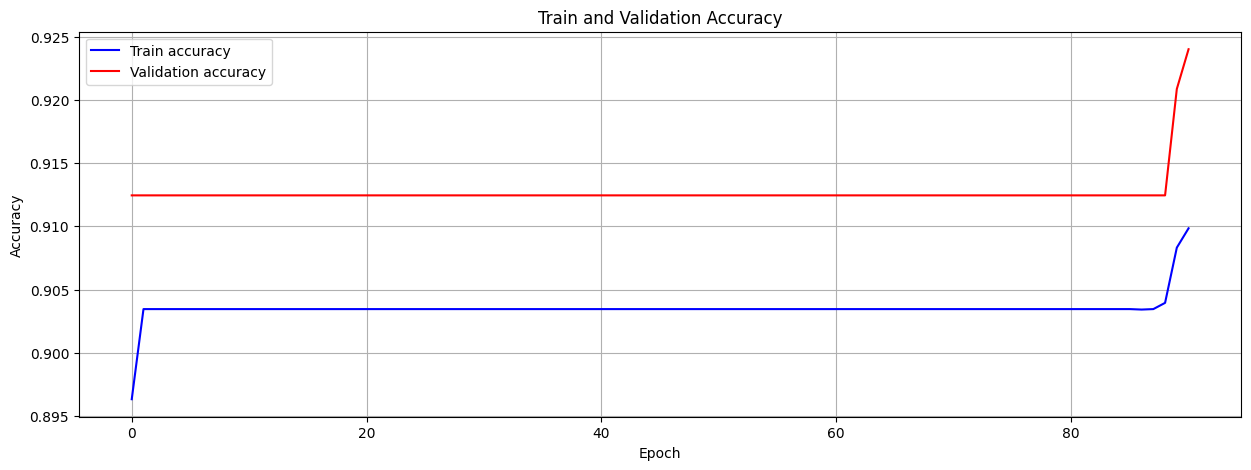

In [34]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history11.epoch, history11.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history11.epoch, history11.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

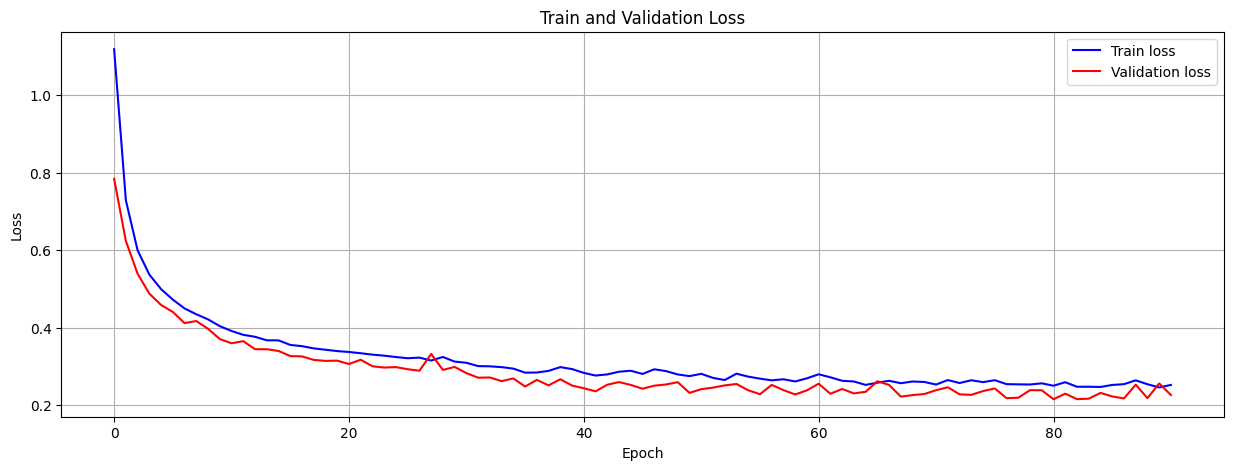

In [35]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history11.epoch, history11.history['loss'], label="Train loss", color='blue')
plt.plot(history11.epoch, history11.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [36]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model using the augmented data generator
history12 = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=len(X_train) // 16,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
36/36 [==============================] - 11s 126ms/step - loss: 0.2884 - accuracy: 0.9034 - val_loss: 0.2333 - val_accuracy: 0.9124
Epoch 2/100
36/36 [==============================] - 5s 132ms/step - loss: 0.2896 - accuracy: 0.9047 - val_loss: 0.2776 - val_accuracy: 0.9124
Epoch 3/100
36/36 [==============================] - 5s 132ms/step - loss: 0.2949 - accuracy: 0.9028 - val_loss: 0.2544 - val_accuracy: 0.9124
Epoch 4/100
36/36 [==============================] - 5s 128ms/step - loss: 0.2866 - accuracy: 0.9038 - val_loss: 0.2540 - val_accuracy: 0.9124
Epoch 5/100
36/36 [==============================] - 5s 131ms/step - loss: 0.2876 - accuracy: 0.9037 - val_loss: 0.2409 - val_accuracy: 0.9124
Epoch 6/100
36/36 [==============================] - 5s 128ms/step - loss: 0.2846 - accuracy: 0.9026 - val_loss: 0.2338 - val_accuracy: 0.9124
Epoch 7/100
36/36 [==============================] - 5s 126ms/step - loss: 0.2821 - accuracy: 0.9027 - val_loss: 0.2432 - val_accuracy: 0.912

In [37]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.45745426
Precision Score = 0.000
Recall Score = 0.000
F1 Score = nan


<ipython-input-37-65cc60482ce1>:19: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2*(p*r)/(p+r)


In [38]:
history_df = pd.DataFrame(history12.history)
history_df['epoch'] = history12.epoch

# Extract the highest accuracy and the lowest loss value
max_accuracy = history_df['accuracy'].max()
min_loss = history_df['loss'].min()


print(f'Highest Accuracy: {max_accuracy}')
print(f'Lowest Loss: {min_loss}')

# Optionally, display the DataFrame
print(history_df)

Highest Accuracy: 0.9047247767448425
Lowest Loss: 0.28211987018585205
        loss  accuracy  val_loss  val_accuracy  epoch
0   0.288448  0.903396  0.233315      0.912444      0
1   0.289555  0.904725  0.277592      0.912444      1
2   0.294884  0.902803  0.254414      0.912444      2
3   0.286567  0.903756  0.254004      0.912444      3
4   0.287559  0.903716  0.240864      0.912444      4
5   0.284589  0.902570  0.233807      0.912444      5
6   0.282120  0.902720  0.243161      0.912444      6
7   0.295255  0.903321  0.236777      0.912444      7
8   0.290716  0.903850  0.237492      0.912444      8
9   0.296380  0.903658  0.244184      0.912444      9
10  0.301594  0.902490  0.263929      0.912444     10


In [39]:
import pandas as pd
# Extract accuracy and loss values from the history object
accuracy = history12.history['accuracy']
val_accuracy = history12.history['val_accuracy']
loss = history12.history['loss']
val_loss = history12.history['val_loss']

# Create a DataFrame to store the values
history_df = pd.DataFrame({
    'epoch': history12.epoch,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'loss': loss,
    'val_loss': val_loss,
    'mean_iou': [IOU_keras] * len(history12.epoch),  # Adding mean IoU to all rows
    'precision': [prec_score] * len(history12.epoch),  # Adding precision to all rows
    'recall': [recall_score] * len(history12.epoch),  # Adding recall to all rows
    'f1_score': [f1_score] * len(history12.epoch)  # Adding F1 score to all rows
})

# Define the path to save the CSV file (adjust the path as needed)
csv_file_path = '/content/drive/MyDrive/training_log_12.csv'

# Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
history_df.to_csv(csv_file_path, index=False)

print("Training history and metrics saved to", csv_file_path)

Training history and metrics saved to /content/drive/MyDrive/training_log_12.csv


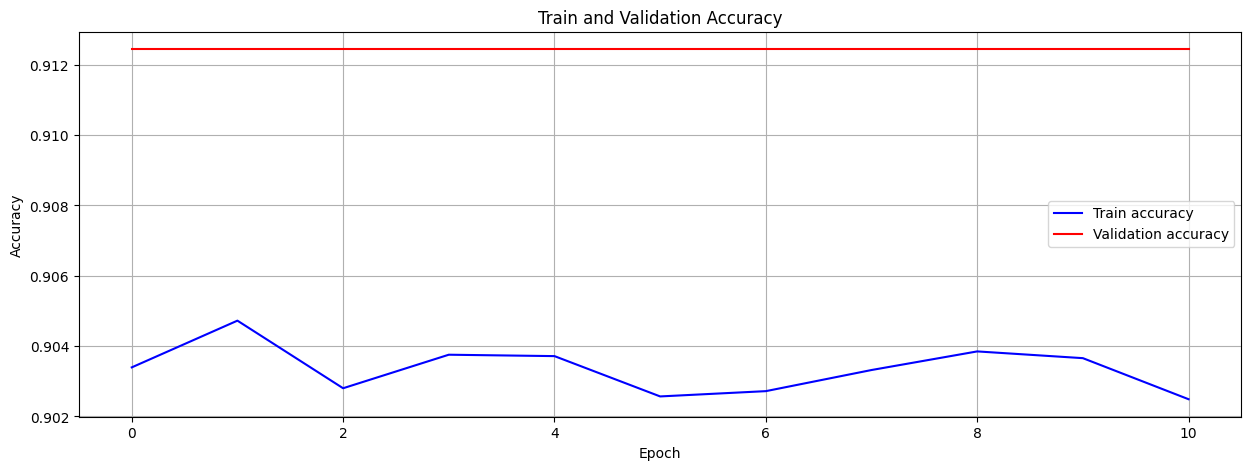

In [40]:
# Plotting Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history12.epoch, history12.history['accuracy'], label="Train accuracy", color='blue',)
plt.plot(history12.epoch, history12.history['val_accuracy'], label="Validation accuracy", color='red')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

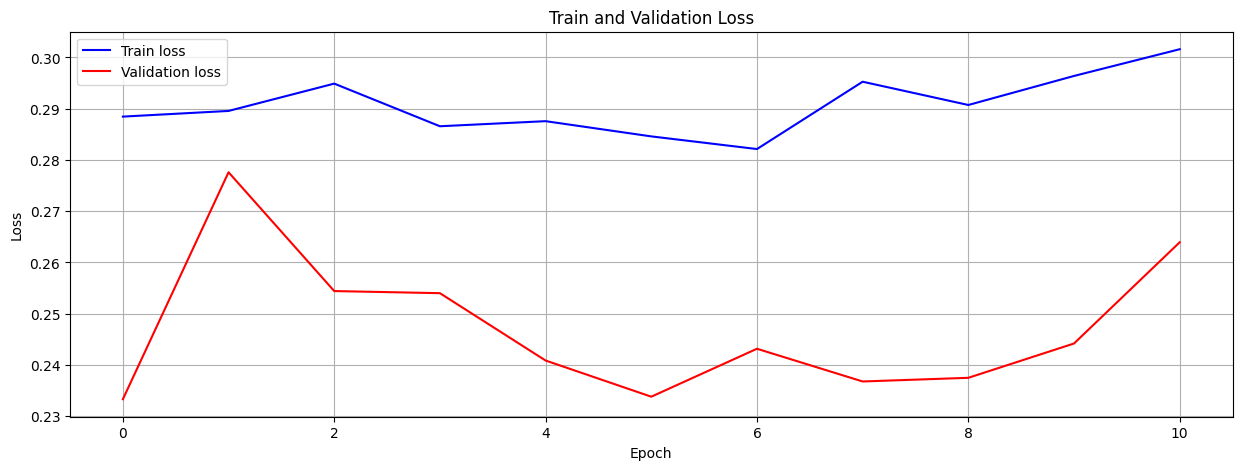

In [41]:
# Plotting Loss
plt.figure(figsize=(15, 5))
plt.plot(history12.epoch, history12.history['loss'], label="Train loss", color='blue')
plt.plot(history12.epoch, history12.history['val_loss'], label="Validation loss", color='red')
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#**Summary**

A fully convolutional network (FCN) is designed for the segmentation task.
Encoder - Multiple convolutional layers with maximum pooling for downsampling.
Bottleneck - dense layer containing the most information.
Decoder - Transpose convolutional layers for upsampling and segmentation map reconstruction.
Skip Connections - Connect layers from encoder to decoder to preserve spatial information.

Model performance was assessed using several metrics:
- **Accuracy**: 0.9758
- **Loss**: 0.058
- **Average IoU**: 0.7469448
- **Precision**: 0.643
- **Let's remind**: 0.771
- **F1-score**: 0.701

These metrics indicate that the model performed well in segmenting breast ultrasound images, with high accuracy and a good balance between precision and recall.
The training process spanned multiple epochs, with early stopping and reduction of the learning rate to prevent overfitting and ensure convergence.
Data augmentation techniques such as rotation, width/height shift, shear, zoom, and horizontal flipping were applied to increase the variability of the training data and improve generalization.
Regularization methods including dropout and L2 regularization were implemented to increase the robustness of the model.
The model showed high accuracy and low loss of training data, indicating effective learning.
Validation accuracy and losses revealed fluctuations, suggesting potential overfitting. However, regularization and early stopping helped alleviate this problem.
Training losses steadily decreased, while validation losses showed some variability, highlighting the challenge of generalizing to unseen data.